In [1]:
import os
from time import sleep
from collections import deque
from collections import namedtuple
import random

import numpy as np
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch
import torch.nn as nn
import torch.nn.functional as F
# !pip install tensorboardX
from tensorboardX import SummaryWriter
# from tensorboardX.global_writer import GlobalSummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import pandas as pd
from tqdm import tqdm_notebook
import warnings

warnings.filterwarnings("ignore")

# Création de class et fonctions utiles à l'étude

## Processus d'Ornstein-Uhlenbeck

Création d'un procesus d'Ornstein-Uhlenbeck (OU) de taille T démarrant à  $p_0=0$:

$$p_t - p_{t-1} = -\rho*p_{t-1} + \sigma*\epsilon_t$$

avec $(\epsilon_t)_t$ suite de lois gaussiennes centrées réduites

In [2]:
def build_ou_process(T=100000, theta=0.1, sigma=0.1, random_state=None):
    """
    Description
    ---------------
    Création d'un procesus d'Ornstein-Uhlenbeck (OU) de taille T démarrant à  p_0=0:
    ```
        p_t - p_{t-1} = -theta*p_{t-1} + sigma*epsilon_t;
    ```
    (epsilon_t)_t suite de lois gaussiennes centrées réduites
    Parameters:
    ---------------
    T : Int, taille du signal.
    theta : Float>0
    sigma : Float>0
    random_state : None or Int, si Int, genère la même séquence de bruit à chaque fois.
    Returns
    ---------------
    np.array de taille (T,), le processus d'OU généré.
    """
    X = np.empty(T)
    t = 0
    x = 0.0
    if random_state is not None:
        rng = np.random.RandomState(random_state)
        normals = rng.normal(0, 1, T)

    else:
        normals = np.random.normal(0, 1, T)

    for t in range(T):
        x += -x * theta + sigma * normals[t]
        X[t] = x
    X /= sigma * np.sqrt(1.0 / 2.0 / theta)
    return X

## Création de l'environnement de trading

Un environnement se compose :
* d'un état $(\pi_t,p_t)$
* d'une action $a_t$
* d'un gain $\textrm{rwd}_t$

$$
    \pi_{t+1} = \pi_t + a_t
$$
$$
    p_{t+1} - p_t = \rho p_t + \eta_t^{(p)}
$$
$$
    r_{t+1} = p_t + \eta_t^{(r)}
$$

In [3]:
class Environment:
    """
    The environment consists of the following:
        - state  : (current_position, next_signal)
        - action : next_position.
        - reward : it depends on our model.
    The signal is built as an OU process.
    """

    def __init__(
        self,
        sigma=0.5,
        rho=1.0,
        T=1000,
        random_state=None,
        lambd=0.5,
        Gamma=0.5,
        cost="trade_0",
        max_pos=10,
        squared_risk=True,
        penalty="none",
        alpha=10,
        beta=10,
        clip=True,
        noise=False,
        noise_std=10,
        noise_seed=None,
        scale_reward=10,
    ):
        """
        Description
        ---------------
        Constructor of class Environment.
        Parameters & Attributes
        ---------------
        sigma          : Float, parameter of price predictor signal
                         p_t - p_{t-1} = -rho*p_{t-1} + sigma*epsilon_t; (epsilon_t)_t
                         are standard normal random variables
        rho          : Float, parameter of price predictor signal
                         p_t - p_{t-1} = -rho*p_{t-1} + sigma*epsilon_t; (epsilon_t)_t
                         are standard normal random variables
        T              : Float, time horizon.
        random_state   : Int or None:
                         - if None, do not use a random state (useful to simulate
                           different paths each time running the simulation).
                         - if Int, use a random state (useful to compare different
                           experimental results).
        lambd          : Float, penalty term of the position in the reward function.
        Gamma            : Float, penalty term of the trade magnitude in the reward
                         function.
        cost           : String in ['trade_0', 'trade_l1', 'trade_l2']
                          - 'trade_0'  : no trading cost.
                          - 'trade_l1' : squared trading cost.
                          - 'trade_l2' : linear trading cost.
        max_pos        : Float > 0, maximum allowed position.
        squared_risk   : Boolean, whether to use the squared risk term or not.
        penalty        : String in ['none', 'constant', 'tanh', 'exp'], the type of
                         penalty to add to penalize positions beyond maxpos.
                         (It is advised to use a tanh penalty in the maxpos setting).
        alpha          : Int, a parameter of the penalty function.
        beta           : Int, a parameter of the penalty function.
        clip           : Boolean, whether to clip positions beyond maxpos or not.
        noise          : Boolean, whether to consider noisy returns or returns equal to
                         predictor values.
        noise_std      : Float, standard deviation of the noise added to the returns.
        noise_seed     : Int, see used to produce the additive noise of the returns.
        scale_reward   : Float>0, parameter that scales the rewards.
        signal         : 1D np.array of shape (T,) containing the sampled OU process.
        it             : Int, the current time iteration.
        pi             : Float, the current position.
        p              : Float, the next value of the signal.
        state          : 2-tuple, the current state: (p, pi).
        done           : Boolean, whether the episode is over or not. Initialized to
                         False.
        state_size     : Int, state size.
        action_size    : Int, action size.
        Returns
        ---------------
        """

        self.sigma = sigma
        self.rho = rho
        self.T = T
        self.lambd = lambd
        self.Gamma = Gamma
        self.cost = cost
        self.max_pos = max_pos
        self.squared_risk = squared_risk
        self.random_state = random_state
        self.signal = build_ou_process(T, sigma, rho, random_state)
        self.it = 0  # First iteration is 0
        self.pi = 0
        self.p = self.signal[self.it + 1]
        self.state = (self.p, self.pi)
        self.done = False
        self.state_size = len(self.state)
        self.action_size = 1
        self.penalty = penalty
        self.alpha = alpha
        self.beta = beta
        self.clip = clip
        self.scale_reward = scale_reward
        self.noise = noise
        self.noise_std = noise_std
        self.noise_seed = noise_seed
        if noise:
            if noise_seed is None:
                self.noise_array = np.random.normal(0, noise_std, T)

            else:
                rng = np.random.RandomState(noise_seed)
                self.noise_array = rng.normal(0, noise_std, T)

    def reset(self, random_state=None, noise_seed=None):
        """
        Description
        ---------------
        Reset the environment to run a new episode.
        Parameters
        ---------------
        random_state : Int or None:
            - if None, do not use a random state (useful to simulate different paths each
              time running the simulation).
            - if Int, use a random state (useful to compare different experimental
              results).
        noise_seed   : Same as random_state but for the noisy returns instead of the
                       predictor signal.
        Returns
        ---------------
        """

        self.signal = build_ou_process(self.T, self.sigma, self.rho, random_state)
        self.it = 0  # First iteration is 0
        self.pi = 0
        self.p = self.signal[self.it + 1]
        self.state = (self.p, self.pi)
        self.done = False
        if self.noise:
            if noise_seed is None:
                self.noise_array = np.random.normal(0, self.noise_std, self.T)

            else:
                rng = np.random.RandomState(noise_seed)
                self.noise_array = rng.normal(0, self.noise_std, self.T)

    def get_state(self):
        """
        Description
        ---------------
        Get the current state of the environment.
        Parameters
        ---------------
        Returns
        ---------------
        2-tuple representing the current state.
        """

        return self.state

    def step(self, action):
        """
        Description
        ---------------
        Aplly action to the environment to modify the state of the agent and get the
        corresponding reward.
        Parameters
        ---------------
        action : Float, the action to perform (next trade to make).
        Returns
        ---------------
        Float, the reward we get by applying action to the current state.
        """

        assert not self.done, (
            "The episode is over, you cannot take another step! "
            "Please reset the environment."
        )
        pi_next_unclipped = self.pi + action
        if self.clip:
            # Clip the next position between -max_pos and max_pos
            pi_next = np.clip(self.pi + action, -self.max_pos, self.max_pos)

        else:
            pi_next = self.pi + action

        if self.penalty == "none":
            pen = 0

        if self.penalty == "constant":
            pen = self.alpha * max(
                0,
                (self.max_pos - pi_next) / abs(self.max_pos - pi_next),
                (-self.max_pos - pi_next) / abs(-self.max_pos - pi_next),
            )

        elif self.penalty == "tanh":
            pen = self.beta * (
                np.tanh(self.alpha * (abs(pi_next_unclipped) - 5 * self.max_pos / 4))
                + 1
            )

        elif self.penalty == "exp":
            pen = self.beta * np.exp(self.alpha * (abs(pi_next) - self.max_pos))

        if self.cost == "trade_0":
            reward = (
                self.p * pi_next - self.lambd * pi_next ** 2 * self.squared_risk - pen
            ) / self.scale_reward

        elif self.cost == "trade_l1":
            if self.noise:
                reward = (
                    (self.p + self.noise_array[self.it]) * pi_next
                    - self.lambd * pi_next ** 2 * self.squared_risk
                    - self.Gamma * abs(pi_next - self.pi)
                    - pen
                ) / self.scale_reward

            else:
                reward = (
                    self.p * pi_next
                    - self.lambd * pi_next ** 2 * self.squared_risk
                    - self.Gamma * abs(pi_next - self.pi)
                    - pen
                ) / self.scale_reward

        elif self.cost == "trade_l2":
            if self.noise:
                reward = (
                    (self.p + self.noise_array[self.it]) * pi_next
                    - self.lambd * pi_next ** 2 * self.squared_risk
                    - self.Gamma * (pi_next - self.pi) ** 2
                    - pen
                ) / self.scale_reward

            else:
                reward = (
                    self.p * pi_next
                    - self.lambd * pi_next ** 2 * self.squared_risk
                    - self.Gamma * (pi_next - self.pi) ** 2
                    - pen
                ) / self.scale_reward

        self.pi = pi_next
        self.it += 1
        self.p = self.signal[self.it + 1]
        self.state = (self.p, self.pi)
        self.done = self.it == (len(self.signal) - 2)
        return reward

    def test(
        self, agent, model, total_episodes=10, random_states=None, noise_seeds=None
    ):
        """
        Description
        ---------------
        Test a model on a number of simulated episodes and get the average cumulative
        reward.
        Parameters
        ---------------
        agent          : Agent object, the agent that loads the model.
        model          : Actor object, the actor network.
        total_episodes : Int, number of episodes to test.
        random_states  : None or List of length total_episodes:
            - if None, do not use random state when generating episodes
              (useful to get an idea about the performance of a single model).
            - if List, generate episodes with the values in random_states (useful when
              comparing different models).
        noise_seeds    : None or List of length total_episodes:
                         - if None, do not use a random state when generating the additive
                           noise of the returns
                         - if List, generate noise with seeds in noise_seeds.
        Returns
        ---------------
        2-tuple : - Float, average cumulative reward over the generated episodes.
                  - Dict, cumulative reward per episode (random state).
        """

        scores = {}
        scores_cumsum = {}
        pnls = {}
        positions = {}
        agent.actor_local = model
        if random_states is not None:
            assert total_episodes == len(
                random_states
            ), "random_states should be a list of length total_episodes!"

        cumulative_rewards = []
        cumulative_pnls = []
        for episode in range(total_episodes):
            episode_rewards = []
            episode_pnls = []
            episode_positions = [0]
            random_state = None if random_states is None else random_states[episode]
            noise_seed = None if noise_seeds is None else noise_seeds[episode]
            self.reset(random_state, noise_seed)
            state = self.get_state()
            done = self.done
            while not done:
                action = agent.act(state, noise=False)
                pi_next = np.clip(self.pi + action, -self.max_pos, self.max_pos)
                episode_positions.append(pi_next)
                reward = self.step(action)
                pnl = reward + (self.lambd * self.pi ** 2) * self.squared_risk
                state = self.get_state()
                done = self.done
                episode_rewards.append(reward)
                episode_pnls.append(pnl)
                if done:
                    total_reward = np.sum(episode_rewards)
                    total_pnl = np.sum(episode_pnls)
                    if random_states is not None:
                        scores[random_states[episode]] = total_reward
                        scores_cumsum[random_states[episode]] = np.cumsum(
                            episode_rewards
                        )
                        pnls[random_states[episode]] = total_pnl
                        positions[random_states[episode]] = episode_positions

                    cumulative_rewards.append(total_reward)
                    cumulative_pnls.append(total_pnl)
                    # print('Episode: {}'.format(episode),
                    #      'Total reward: {:.2f}'.format(total_reward))

        return (
            np.mean(cumulative_rewards),
            scores,
            scores_cumsum,
            np.mean(cumulative_pnls),
            positions,
        )

    def apply(self, state, thresh=1, lambd=None, Gamma=None):
        """
        Description
        ---------------
        Apply solution with a certain band and slope outside the band, otherwise apply the
        myopic solution.
        Parameters
        ---------------
        state      : 2-tuple, the current state.
        thresh     : Float>0, price threshold to make a trade.
        lambd      : Float, slope of the solution in the non-banded region.
        Gamma        : Float, band width of the solution.
        Returns
        ---------------
        Float, the trade to make in state according to this function.
        """

        p, pi = state
        if lambd is None:
            lambd = self.lambd

        if Gamma is None:
            Gamma = self.Gamma

        if not self.squared_risk:
            if abs(p) < thresh:
                return 0
            elif p >= thresh:
                return self.max_pos - pi
            elif p <= -thresh:
                return -self.max_pos - pi

        else:
            if self.cost == "trade_0":
                return p / (2 * lambd) - pi

            elif self.cost == "trade_l2":
                return (p + 2 * Gamma * pi) / (2 * (lambd + Gamma)) - pi

            elif self.cost == "trade_l1":
                if p < -Gamma + 2 * lambd * pi:
                    return (p + Gamma) / (2 * lambd) - pi
                elif -Gamma + 2 * lambd * pi <= p <= Gamma + 2 * lambd * pi:
                    return 0
                elif p > Gamma + 2 * lambd * pi:
                    return (p - Gamma) / (2 * lambd) - pi

    def test_apply(
        self,
        total_episodes=10,
        random_states=None,
        thresh=1,
        lambd=None,
        Gamma=None,
        noise_seeds=None,
        max_point=6.0,
        n_points=1000,
    ):
        """
        Description
        ---------------
        Test a function with certain slope and band width for each reward model (with and
        without trading cost, and depending on the penalty when trading cost is used).
        When Gamma and lambd are not provided, use the myopic solution.
        Parameters
        ---------------
        total_episodes : Int, number of episodes to test.
        random_states  : None or List of length total_episodes:
                         - if None, do not use random state when generating episodes
                           (useful to get an idea about the performance of a single
                           model).
                         - if List, generate episodes with the values in random_states
                           (useful when comparing different models).
        lambd          : Float, slope of the solution in the non-banded region.
        Gamma            : Float, band width of the solution.
        max_point      : Float, the maximum point in the grid [0, max_point]
        n_points       : Int, the number of points in the grid.
        Returns
        ---------------
        5-tuple : - Float, average cumulative reward over the generated episodes.
                  - Dict, cumulative reward per episode (random state).
                  - Dict, cumulative sum of the reward at each time step per episode.
                  - Dict, pnl per episode.
                  - Dict, positions per episode.
        """

        scores = {}
        scores_cumsum = {}
        pnls = {}
        positions = {}
        if random_states is not None:
            assert total_episodes == len(
                random_states
            ), "random_states should be a list of length total_episodes!"

        cumulative_rewards = []
        cumulative_pnls = []
        for episode in range(total_episodes):
            episode_rewards = []
            episode_pnls = []
            episode_positions = [0]
            random_state = None if random_states is None else random_states[episode]
            noise_seed = None if noise_seeds is None else noise_seeds[episode]
            self.reset(random_state, noise_seed)
            state = self.get_state()
            done = self.done
            while not done:
                action = self.apply(state, thresh=thresh, lambd=lambd, Gamma=Gamma)
                reward = self.step(action)
                pnl = reward + (self.lambd * self.pi ** 2) * self.squared_risk
                state = self.get_state()
                done = self.done
                episode_rewards.append(reward)
                episode_pnls.append(pnl)
                episode_positions.append(state[1])
                if done:
                    total_reward = np.sum(episode_rewards)
                    total_pnl = np.sum(episode_pnls)
                    if random_states is not None:
                        scores[random_states[episode]] = total_reward
                        scores_cumsum[random_states[episode]] = np.cumsum(
                            episode_rewards
                        )
                        pnls[random_states[episode]] = episode_pnls
                        positions[random_states[episode]] = episode_positions

                    cumulative_rewards.append(total_reward)
                    cumulative_pnls.append(total_pnl)

        return (
            np.mean(cumulative_rewards),
            scores,
            scores_cumsum,
            np.mean(cumulative_pnls),
            positions,
        )

## Gestion du Replay Buffer

La gestion du *Replay Buffer* se fait par *Prioritized Experience Replay. Un *batch* de tuples $(s_{t_j},a_{t_j},\textrm{rwd}_{t_j},s_{t_{j+1}})_{1\le j\le b}$ de taille $b$ est échantillonné du *replay buffer*. Chaque tuple représentant de "l'expérience",ils sont pondérés selon leurs erreusr TD (*Temporal Difference*) : 

$$\delta(s,a,\textrm{rwd},s')=\textrm{rwd} + \gamma \max\limits_{a'}\mathcal{Q}(s',a')-\mathcal{Q}(s,a)$$
$$P(i)=\dfrac{p_i^\alpha}{\sum_k p_k^\alpha}, \, \, 1\le i \le N, \, \, 0\le \alpha\le1$$
avec $N$ la taille du *replay buffer*, $p_i = |\delta_i| + \varepsilon$, $\varepsilon$ un petit nombre poitif pour assurer une probabilité non nulle de tirage.

In [4]:
class Memory:
    """
    Class of the uniform experience replay memory.
    """

    def __init__(self, max_size):
        """
        Description
        -------------
        Constructor of class Memory.
        Attributes & Parameters
        -------------
        max_size : Int, the maximum size of the replay memory
        buffer   : collections.deque object of maximum length max_size, the container
                   representing the replay memory
        """

        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        """
        Description
        -------------
        Add experience to the replay buffer.
        Parameters
        -------------
        experience : 5-tuple representing a transiction.
        """

        self.buffer.append(experience)

    def sample(self, batch_size):
        """
        Description
        -------------
        Randomly sample "batch_size" experiences from the replay buffer.
        Parameters
        -------------
        batch_size : Int, the number of experiences to sample.
        Returns
        -------------
        List containing the sampled experiences.
        """

        return random.sample(self.buffer, batch_size)


class Node:

    # This counter is a class attribute and will define indices of leaves in the array
    # where we store them.
    count = 0
    # Storing the index will help us deal with the reaplay buffer when it gets saturated.
    saturated = False  # This boolean will turn True when Node.count >= max_size

    def __init__(
        self,
        max_size,
        index_heap=None,
        l_child=None,
        r_child=None,
        children_heap=[],
        parent=None,
        parent_heap=None,
        value=0.0,
        sliding="oldest",
    ):
        """
        Description
        ------------------------
        Constructor of class Node, this class represents objects describing how nodes are
        interlinked in both a sum tree and a heap.
        Parameters & Attributes
        ------------------------
        max_size      : Int, maximum size of the replay buffer where we store the leaves.
        index         : Int, index of the leaf on the storing array (only useful when the
                        node is actually a leaf).
        index_heap    : Int, index of the leaf on the storing array of the heap.
        l_child       : None or object of class Node, Left Child in the sum tree.
        r_child       : None or object of class Node, Right Child in the sum tree.
        children_heap : Sorted List containing the children of the node in the heap.
                        Sorting makes method sift_down of Heap easy.
        parent        : None or object of class Node, parent in sum tree. Setting the
                        parent helps us updating the value of each node
                        starting from a changed leaf up to the root.
        parent_heap   : None or object of class Node, parent in the heap.
        value         : Float, sum over all values of the subtree spanned by this node as
                        a root (TD error magnitude in case of a leaf).
        sliding       : String in ['oldest', 'random'], when the tree gets saturated and a
                        new experience comes up.
                           - 'oldest' : Oldest leaves are the first to be changed.
                           - 'random' : Random leaves are changed.
        leaf          : Boolean, whether the node is a leaf in the sum tree or not (True
                        when both l_child and r_child are None).
        leaf_heap     : Boolean, whether the node is a leaf in the heap or not (True when
                        both l_child_heap and r_child_heap are None).
        level         : Int, it specifies the hierarchy of nodes in the sum tree starting
                        from the leaves (0) and up to the root.
        complete      : Boolean, whether the node has both of its children in the same
                        level or not.
        """

        self.max_size = max_size
        self.index = Node.count
        self.index_heap = index_heap
        self.l_child = l_child
        self.r_child = r_child
        self.children_heap = sorted(children_heap, reverse=True)
        self.parent = parent
        self.parent_heap = parent_heap
        self.value = value
        self.leaf = (l_child is None) & (r_child is None)
        self.leaf_heap = len(children_heap) == 0
        self.complete = False
        if self.leaf:
            # Set the leaf index to class attribute count.
            self.index = Node.count
            # Increment class attribute count to account for tree saturation.
            Node.count += 1
            self.level = 0  # Level 0 because it is a leaf.
            # Update class attribute count (tree saturation status).
            Node.saturated = Node.count >= self.max_size

        elif self.r_child is None:
            # Every node that is not a leaf has at least a left child, in case it does not
            # have a right child, the node's level is the increment by 1 of the level of
            # its left child.
            self.level = self.l_child.level + 1

        else:
            # In case the node has both children, it takes the increment by 1 of the
            # minimum level. The reason is that when the tree evolves
            # by adding new leaves, this node will eventually have its children change
            # until reaching the mentioned minimum level.
            self.level = min(self.l_child.level, self.r_child.level) + 1
            self.complete = self.l_child.level == self.r_child.level

    def reset_count():
        """
        Description
        ------------------------
        Class method, resets class attribute count to 0
        Parameters
        ------------------------
        Returns
        ------------------------
        """
        Node.count = 0
        Node.saturated = False

    def update_complete(self):
        """
        Description
        ------------------------
        Update the status (complete or not) of the current node, this can be triggered by
        an update of its children.
        Parameters
        ------------------------
        Returns
        ------------------------
        """

        assert not self.leaf, "Do not update the status of a leaf"
        if self.r_child is None:
            pass

        else:
            self.complete = self.l_child.level == self.r_child.level

    def update_level(self):
        """
        Description
        ------------------------
        Update the level of the current node, this can be triggered by an update of its
        children.
        Parameters
        ------------------------
        Returns
        ------------------------
        """

        # Since we obviously do not update the level of a leaf, the if self.leaf condition
        # can be omitted.
        if self.r_child is None:
            # Every node that is not a leaf has at least a left child, in case it does not
            # have a right child, the node's level is the increment by 1 of the level of
            # its left child.
            self.level = self.l_child.level + 1

        else:
            # In case the node has both children, it takes the increment by 1 of the
            # minimum level. The reason is that when the tree evolves by adding new
            # leaves, this node will eventually have its children change until reaching
            # the mentioned minimum level.
            self.level = min(self.l_child.level, self.r_child.level) + 1

    def update_value(self):
        """
        Description
        ------------------------
        Update the value of the node after setting its left and right children.
        Parameters
        ------------------------
        Returns
        ------------------------
        """

        self.value = self.l_child.value + self.r_child.value

    def update(self):
        """
        Description
        ------------------------
        Update level, status and value attributes of the node.
        Parameters
        ------------------------
        Returns
        ------------------------
        """

        self.update_level()
        self.update_complete()
        self.update_value()

    def update_leaf_heap(self):
        """
        Description
        ------------------------
        Update the attribute leaf_heap.
        Parameters
        ------------------------
        Returns
        ------------------------
        """

        self.leaf_heap = len(self.children_heap) == 0

    def set_l_child(self, l_child):
        """
        Description
        ------------------------
        Set the left child of the node.
        Parameters
        ------------------------
        l_child : Object of class Node, Left child.
        Returns
        ------------------------
        """

        self.l_child = l_child

    def set_r_child(self, r_child):
        """
        Description
        ------------------------
        Set the right child of the node.
        Parameters
        ------------------------
        r_child : Object of class Node, Right child.
        Returns
        ------------------------
        """

        self.r_child = r_child

    def set_children_heap(self, children_heap):
        """
        Description
        ------------------------
        Set the nodes' children in the heap.
        Parameters
        ------------------------
        children_heap : sorted List of the children nodes, set their parent to the current
        node.
        Returns
        ------------------------
        """

        self.children_heap = children_heap
        self.children_heap.sort(reverse=True)
        for child in children_heap:
            child.set_parent_heap(self)

    def replace_child_heap(self, child_origin, child_new):
        """
        Description
        ------------------------
        Replace a child among the children of the node in the heap.
        Parameters
        ------------------------
        child_origin : Object of class Node, the child we want to replace, set its parent
                       later according to the usage.
        child_new : Object of class Node, the new child, set its parent to the current
                    node.
        Returns
        ------------------------
        """

        assert child_origin in self.children_heap, (
            "The child you want to replace does not belong to "
            "the children of current node!"
        )
        for i, child in enumerate(self.children_heap):
            if child == child_origin:
                self.children_heap[i] = child_new

        self.children_heap.sort(reverse=True)
        child_new.set_parent_heap(self)

    def add_child_heap(self, child):
        """
        Description
        ------------------------
        Add a new child in the heap to the current node when it does not altready have two
        children.
        Parameters
        ------------------------
        child : Object of class Node, the child we want to add, set its parent to the
                current node.
        Returns
        ------------------------
        """

        assert len(self.children_heap) < 2, (
            "The node has already 2 children, "
            "you cannot add a child, consider replacing operation."
        )
        self.children_heap.append(child)
        self.children_heap.sort(reverse=True)
        child.set_parent_heap(self)

    def set_parent_heap(self, parent_heap):
        """
        Description
        ------------------------
        Set the nodes' children in the heap.
        Parameters
        ------------------------
        parent_heap : Object of class Node, the parent we would like to set to the node in
        the heap.
        Returns
        ------------------------
        """

        self.parent_heap = parent_heap

    def set_index_heap(self, index_heap):
        """
        Description
        ------------------------
        Set the index of the current node in the heap.
        Parameters
        ------------------------
        index_heap : Int, the index in the heap to set to the current node.
        Returns
        ------------------------
        """

        self.index_heap = index_heap

    def __lt__(self, node):
        """
        Description
        ------------------------
        Comparing method, this proves useful when sorting objects inside lists or heaps.
        In fact we define it such that the root of a heap containing multiple nodes is the
        node with the highest priority.
        Parameters
        ------------------------
        node : Object of class Node, another node we compare the current one with.
        Returns
        ------------------------
        """

        return self.value < node.value


def retrieve_leaf(node, s):
    """
    Description
    ------------------------
    Function describing the retrieval strategy of a leaf when sampling, starting from node
    and given the random number 0 <= s <= node.value
    Parameters
    ------------------------
    node : Object of class Node, the root of the subtree we consider.
    s    : Float s.t 0 <= s <= node.value used in sampling.
    Returns
    ------------------------
    Int, index of the retrieved leaf in the sum tree.
    """

    if node.leaf:
        return node.index

    elif node.l_child.value >= s:
        return retrieve_leaf(node.l_child, s)

    else:
        return retrieve_leaf(node.r_child, s - node.l_child.value)


# Vectorized retrieve_leaf
retrieve_leaf_vec = np.vectorize(retrieve_leaf, excluded=set([0]))


def retrieve_value(node):
    """
    Description
    ------------------------
    Retrieve the value of a node, this function is just intended to be vectorized.
    Parameters
    ------------------------
    node : Object of class Node, the considered node.
    Returns
    ------------------------
    Float, the value of the considered node.
    """

    return node.value


# Vectorized retrieve_valuew
retrieve_value_vec = np.vectorize(retrieve_value)


class Heap:
    def __init__(self):
        """
        Description
        ------------------------
        Constructor of class Heap.
        Parameters & Attributes
        ------------------------
        track : List, the table representation of the heap.
        root  : Object of class Node, root of the heap.
        """

        self.track = []
        self.root = None
        self.last_child = None

    def swap(self, child, parent):
        """
        Description
        ------------------------
        Swap the relation parent-child between two nodes, while keeping the tree intact.
        Parameters
        ------------------------
        child  : Object of class Node, the child node.
        parent : Object of class Node, the parent node.
        Returns
        ------------------------
        """

        # We need to keep track of the child node children, the parent node children to
        # make the suitable exchanges and also the parent's parent to replace parent in
        # its children by child.
        child_children_heap, parent_children_heap, grand_parent = (
            child.children_heap,
            parent.children_heap,
            parent.parent_heap,
        )
        # Swap the indices of child and parent in the heap.
        child_index_heap, parent_index_heap = child.index_heap, parent.index_heap
        child.set_index_heap(parent_index_heap)
        parent.set_index_heap(child_index_heap)
        # Swap the children.
        # The parent takes the children of its child.
        parent.set_children_heap(child_children_heap)
        # The child takes the children of its parent
        child.set_children_heap(parent_children_heap)
        # and replaces itself in its children by its parent.
        child.replace_child_heap(child, parent)
        if grand_parent is not None:
            # When grand parent exists, child takes the place of parent in the grand
            # parents' children
            grand_parent.replace_child_heap(parent, child)

        else:
            # When grand parent does not exist, it means parent is the root, we need then
            # to set child as the new root when swapped with parent.
            child.set_parent_heap(None)
            self.root = child

        # Now that child and parent are internally updated, update their positioning in
        # the tracking list.
        self.track[child.index_heap] = child
        self.track[parent.index_heap] = parent

    def sift_up(self, node):
        """
        Description
        ------------------------
        Update the structure of the heap when one of its internal nodes changes its value
        to a higher one.
        Parameters
        ------------------------
        node    : Object of class Node, the modified node.
        Returns
        ------------------------
        changed : Boolean, whether the heap has changed by performing the sift_up or not.
        """

        parent = node.parent_heap
        changed = False
        while (parent is not None) and (node > parent):
            self.swap(node, parent)
            parent = node.parent_heap
            # Entering the while loop means that we modify the heap.
            changed = True

        return changed

    def sift_down(self, node):
        """
        Description
        ------------------------
        Update the structure of the heap when one of its internal nodes changes its value
        to a lower one.
        Parameters
        ------------------------
        node : Object of class Node, the modified node.
        Returns
        ------------------------
        changed : Boolean, whether the heap has changed by performing the sift_up or not.
        """

        children = node.children_heap
        changed = False
        while (len(children) != 0) and (children[0] > node):
            self.swap(children[0], node)
            children = node.children_heap
            # Entering the while loop means that we modify the heap.
            changed = True

        return changed

    def update(self, node, value):
        """
        Description
        ------------------------
        Update the heap when changing the value of a node.
        Parameters
        ------------------------
        node  : Object of class Node, change de value of this node.
        value : Float, new value we assign to node
        Returns
        ------------------------
        """

        value_prev = node.value
        node.value = value
        self.sift_down(node) if value < value_prev else self.sift_up(node)

    def insert(self, node):
        """
        Description
        ------------------------
        Insert a new node to the heap.
        Parameters
        ------------------------
        node : Object of class Node, the new node to be inserted.
        Returns
        ------------------------
        """

        self.track.append(node)
        node.set_index_heap(len(self.track) - 1)
        if self.root is None:
            self.root = node

        else:
            parent = self.track[(node.index_heap - 1) // 2]
            parent.add_child_heap(node)
            # changed = self.sift_up(node)


class SumTree:
    def __init__(self, max_size):
        """
        Description
        ------------------------
        Constructor of class SumTree.
        Parameters & Attributes
        ------------------------
        max_size : Int, maximum number of leaves.
        sub_left : Object of class Node or None, root of the complete subtree built. It is
                   always the left child of the incoming root.
        parents : collections.deque object, container of parents nodes (helps build the
                  tree).
        children : collections.deque object, container of children nodes (helps build the
                   tree).
        complete : Boolean, True : - The number of leaves is a power of 2, parents &
                                     children are empty, sub_left is the root.
                            False : - The number of leaves isn't a power of 2, parents &
                                      children aren't empty, parents[0] is the root.
        """

        self.max_size = max_size
        self.sub_left = None
        self.parents = deque()
        self.children = deque()
        self.complete = False

    def add_leaf(self, node):
        """
        Description
        ------------------------
        Add a new leaf to the tree.
        Parameters
        ------------------------
        node : Object of class Node, the new leaf representing the transition to be added
        to the replay buffer.
        Returns
        ------------------------
        """

        if self.sub_left is None:
            # Add leaf initially to the empty tree.
            self.sub_left = node
            self.complete = True  # The tree is now complete.

        else:  # The tree is not empty
            root = Node(self.max_size, l_child=self.sub_left)  # Define the new root.
            self.sub_left.parent = root  # Set the corresponding parent.
            # Add the new root to the left of Parents container.
            self.parents.appendleft(root)
            # Add the new leaf to the right of Children container.
            self.children.append(node)
            self.complete = False  # The tree is not complete.
            if len(self.parents) >= 2:
                # Set the left child of last parent to children[-2]
                self.parents[-1].l_child = self.children[-2]
                # Set parents[-1] as the parent of children[-2]
                self.children[-2].parent = self.parents[-1]
                # Set the right child of last parent to children[-1]
                self.parents[-1].r_child = self.children[-1]
                # Set parents[-1] as the parent of children[-1]
                self.children[-1].parent = self.parents[-1]
                # Update the attributes of the last parent.
                self.parents[-1].update()
                while self.parents[-1].complete:
                    # Collapsing loop
                    node = self.parents.pop()  # Pop the last parent node.
                    self.children.pop()  # Pop the last child.
                    # Set the last parent (which is complete) to the last child,
                    self.children[-1] = node
                    # The three steps above are what I call a collapse.
                    # If we reach (len(self.parents) == 1) after the collapse,
                    if len(self.parents) == 1:
                        # we must break the while loop.
                        break

                    # Set the left child of last parent to children[-2]
                    self.parents[-1].l_child = self.children[-2]
                    # Set parents[-1] as the parent of children[-2]
                    self.children[-2].parent = self.parents[-1]
                    # Set the right child of last parent to children[-1]
                    self.parents[-1].r_child = self.children[-1]
                    # Set parents[-1] as the parent of children[-1]
                    self.children[-1].parent = self.parents[-1]
                    # Update the attributes of the last parent.
                    self.parents[-1].update()

                # In case we did not collapse every node (except the root)
                if len(self.parents) >= 2:
                    for i in range(-2, -len(self.parents), -1):
                        # Set the left child as we did before in the collapsing loop.
                        self.parents[i].l_child = self.children[i - 1]
                        # Set the corresponding parent.
                        self.children[i - 1].parent = self.parents[i]
                        # Set the right child to the next parent this time.
                        self.parents[i].r_child = self.parents[i + 1]
                        # Set the corresponding parent.
                        self.parents[i + 1].parent = self.parents[i]
                        # Update the attributes of the last parent.
                        self.parents[i].update()

                    # Treating the root independently.
                    # Since len(self.parents) >= 2, set its right child to the next
                    # parent,
                    self.parents[0].r_child = self.parents[1]
                    # Recall that the left child of the root is already set to
                    # self.sub_left .
                    # Update the attributes of the root.
                    self.parents[0].update()

                # In case every node (except the root) collapsed.
                else:
                    # Set the right child to the first child (the only child at this
                    # point).
                    self.parents[0].r_child = self.children[0]
                    # Set the corresponding parent.
                    self.children[0].parent = self.parents[0]
                    # Update the attributes of the root.
                    self.parents[0].update()
                    # Check if we can collapse the root.
                    if self.parents[0].complete:
                        root = self.parents.pop()  # Pop the root.
                        self.children.pop()  # Pop the last child.
                        # We have now a complete tree with root sub_left.
                        self.sub_left = root
                        self.complete = True  # The tree is complete.

            elif len(self.parents) == 1:
                # Set the right child to the first child (the only child at this point).
                self.parents[0].r_child = self.children[0]
                self.children[0].parent = self.parents[
                    0
                ]  # Set the corresponding parent.
                self.parents[0].update()
                # Check if we can collapse the root.
                if self.parents[0].complete:
                    root = self.parents.pop()  # Pop the root.
                    self.children.pop()  # Pop the last child.
                    # We have now a complete tree with root sub_left.
                    self.sub_left = root
                    self.complete = True  # The tree is complete.

    def sample_batch(self, batch_size=64):
        """
        Description
        ------------------------
        Sample batch size leaves according to the distribution expressed by their values.
        Parameters
        ------------------------
        batch_size : Int, the number of leaves to be sampled.
        Returns
        ------------------------
        np.array of shape (batch_size,) containing the indices of the leaves to be sampled
        """

        # Retrieve the root.
        root = self.sub_left if (len(self.parents) == 0) else self.parents[0]
        ss = np.random.uniform(0, root.value, batch_size)
        return retrieve_leaf_vec(root, ss)

    def update(self, leaf):
        """
        Description
        ------------------------
        Update the tree by propagating new value of a leaf up to the root.
        Parameters
        ------------------------
        leaf : Object of class Node, the leaf which value we have changed.
        Returns
        ------------------------
        """

        parent = leaf.parent
        parent.update_value()
        parent = parent.parent
        while parent is not None:
            parent.update_value()
            parent = parent.parent

    def retrieve_root(self):
        """
        Description
        ------------------------
        Retrieve the root node of the tree.
        Parameters
        ------------------------
        Returns
        ------------------------
        Object of class Node, the root of the tree.
        """

        return self.sub_left if len(self.parents) == 0 else self.parents[0]


# def retrieve_first(couple):
#    return couple[0]


def retrieve_first(couple):
    return couple[0]


retrieve_first_vec = np.vectorize(retrieve_first)


class PrioritizedMemory:
    """
    Class of the prioritized experience replay memory.
    """

    def __init__(self, max_size, sliding="oldest"):
        """
        Description
        -------------
        Constructor of class PrioritizedMemory.
        Parameters & Attributes
        ------------------------
        max_size : Int, the maximum size of the replay memory.
        sliding : String in ['oldest', 'random'], when the tree gets saturated and a new
                  experience comes up.
                        - 'oldest' : Oldest leaves are the first to be changed.
                        - 'random' : Random leaves are changed.
        buffer : 2D np.array of shape (2, max_size), the container representing the replay
                 memory.
                       - buffer[0, :] : experiences, 5-tuples representing transictions.
                       - buffer[1, :] : leaves, Objects of class Node representing the
                                        corresponding experiences.
        sliding : String in ['oldest', 'random'], when the tree gets saturated and a new
                  experience comes up.
                       - 'oldest' : Oldest leaves are the first to be changed.
                       - 'random' : Random leaves are changed.
        tree : SumTree object, the sum-tree which leaves represent the stored transitions.
        """

        self.max_size = max_size
        assert sliding in [
            "oldest",
            "random",
        ], "sliding parameter must be either 'oldest' or 'random'"
        self.sliding = sliding
        self.buffer = np.empty((2, max_size), dtype=object)
        self.tree = SumTree(max_size=max_size)  # Initialize Sum-Tree
        self.heap = Heap()  # Initialize Heap

    def update(self, index, priority):
        """
        Description
        -------------
        Change the priority of an already stored leaf and propagate the information up to
        the root of the sum tree.  We also need to update this priority and propagate its
        impact in the heap.
        Parameters
        -------------
        index : Int, index of the leaf we want to propagate the value up to the root from.
        priority : Float > 0, (|delta| + epsilon)^alpha with delta the TD error.
        Returns
        -------------
        """

        # node points to the node object we want to update.
        node = self.buffer[1, index]
        # Update the heap by either a sift_down or a sift_up.
        self.heap.update(node, priority)
        # Notice that the priority of node already changed when updated in the heap,
        self.tree.update(node)
        # thus directly running the sum tree update.

    def add(self, experience, priority):
        """
        Description
        -------------
        Add the tuple (experience, leaf) to the replay buffer.
        Parameters
        -------------
        experience : tuple (state, action, reward, next_state) representing a transition.
        priority   : Float > 0, (|delta| + epsilon)^alpha with delta the TD error.
        Returns
        -------------
        """

        # If the tree is not saturated.
        if not Node.saturated:
            # Create the leaf corresponding to the transition.
            leaf = Node(max_size=self.max_size, value=priority)
            # Fill the replay buffer.
            self.buffer[:, leaf.index] = np.array([experience, leaf], dtype=object)
            # Add new leaf to the tree.
            self.tree.add_leaf(leaf)
            # Add object leaf to the heap, notice that it is a leaf in the sum-tree,
            self.heap.insert(leaf)

        else:
            if self.sliding == "oldest":
                index = Node.count % self.max_size
                # We need to increment Node.count sor that we cycle again through
                Node.count += 1
                # indices from 0 to (self.max_size-1)
            elif self.sliding == "random":
                # No need to increment Node.count here since its value does not matter
                # anymore.
                index = np.random.randint(0, self.max_size)

            leaf = self.buffer[1, index]
            # When the tree gets saturated, replace the previous element in the buffer at
            # index
            self.buffer[:, index] = np.array([experience, leaf])
            # and point to the same previous leaf object in memory to change its value,
            self.update(index, priority)
            # then propagate the information up to the root.

    def sample(self, batch_size):
        """
        Description
        -------------
        Randomly sample "batch_size" experiences from the replay buffer.
        Parameters
        -------------
        tree : Object of class SumTree, we plug it as an agument of the method for memory
               efficiency purpose.
        batch_size : Int, the number of experiences to sample.
        Returns
        -------------
        np.array of shape (batch_size,) : array containing the sampled experiences.
        np.array of shape (batch_size,) : array containing the indices in the replay
                                          buffer of the sampled experiences.
        """

        # Sample indices using the tree.
        indices = self.tree.sample_batch(batch_size)
        # Retrieve the 1st element of each couple (experiences) as well as their indices
        # in the buffer (to access the leaves).
        return list(self.buffer[0, indices]), indices

    def highest_priority(self):
        """
        Description
        -------------
        Return the highest priority in the replay buffer.
        Parameters
        -------------
        Returns
        -------------
        0 < Float <= 1, the highest priority in the replay buffer.
        """

        priority = self.heap.root.value
        return priority

    def n_experiences(self):
        """
        Description
        -------------
        Return the number of experiences stored in the replay buffer so far.
        Parameters
        -------------
        Returns
        -------------
        Int, number of experiences
        """

        return len(self.heap.track)

    def sum_priorities(self):
        """
        Description
        -------------
        Return the sum of all priorities, useful to compute sampling probabilities from
        priorities
        Parameters
        -------------
        Returns
        -------------
        Float > 0, sum of all priorities.
        """

        root = self.tree.retrieve_root()
        return root.value

    def retrieve_priorities(self, indices):
        """
        Description
        -------------
        Return the priorities of experiences placed in indices of the replay buffer.
        Parameters
        -------------
        indices : 1D np.array, indices in the replay buffer of experiences of interest.
        Returns
        -------------
        1D np.array containing the priorities of experiences.
        """

        return retrieve_value_vec(self.buffer[1, indices])

## Création des classes Acteur et Critique

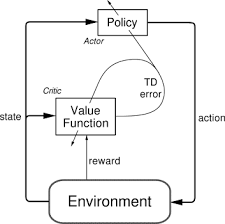

In [5]:
def hidden_init(layer):
    """
    Description
    -------------
    Initialize the hidden layers (except the output layer) with Uniform(-1/sqrt(fan_in),
    1/sqrt(fan_in)) Where fan_in is the number of units in the layer
    Parameters
    -------------
    layer : torch.nn.modules.linear.Linear object, the fully connected layer to
            initialize.
    Returns
    -------------
    -1/sqrt(fan_in), 1/sqrt(fan_in)
    """

    fan_in = layer.weight.data.size()[1]  # Not sure if it should be [1] instead.
    lim = 1.0 / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    def __init__(self, state_size, action_size=1, seed=0, fc1_units=16, fc2_units=8):
        """
        Description
        -------------
        Actor constructor.
        Parameters
        -------------
        state_size  : Int, Dimension of each state
        action_size : Int, Dimension of each action
        seed        : Int, Random seed
        fc1_units   : Int, Number of nodes in first hidden layer
        fc2_units   : Int, Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        """
        Description
        -------------
        Reinitialize the layers
        """

        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc1.bias.data.fill_(0)
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc2.bias.data.fill_(0)
        self.fc3.weight.data.uniform_(-3e-4, 3e-4)
        self.fc3.bias.data.fill_(0)

    def forward(self, state):
        """
        Description
        -------------
        Apply a forward pass on a state with Actor network.
        """

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class Critic(nn.Module):
    def __init__(self, state_size, action_size=1, seed=0, fcs1_units=64, fc2_units=32):
        """
        Description
        -------------
        Critic constructor
        Parameters
        -------------
        state_size (int): Dimension of each state
        action_size (int): Dimension of each action
        seed (int): Random seed
        fcs1_units (int): Number of nodes in the first hidden layer
        fc2_units (int): Number of nodes in the second hidden layer
        """

        super(Critic, self).__init__()
        self.fcs1 = nn.Linear(state_size + action_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        """
        Description
        -------------
        Reinitialize the layers
        """

        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fcs1.bias.data.fill_(0)
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc2.bias.data.fill_(0)
        self.fc3.weight.data.uniform_(-3e-4, 3e-4)
        self.fc3.bias.data.fill_(0)

    def forward(self, state, action):
        """
        Description
        -------------
        Apply a forward pass on a state with Critic network.
        """

        x = torch.cat((state, action), dim=1)
        x = F.relu(self.fcs1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Création de l'agent DDPG

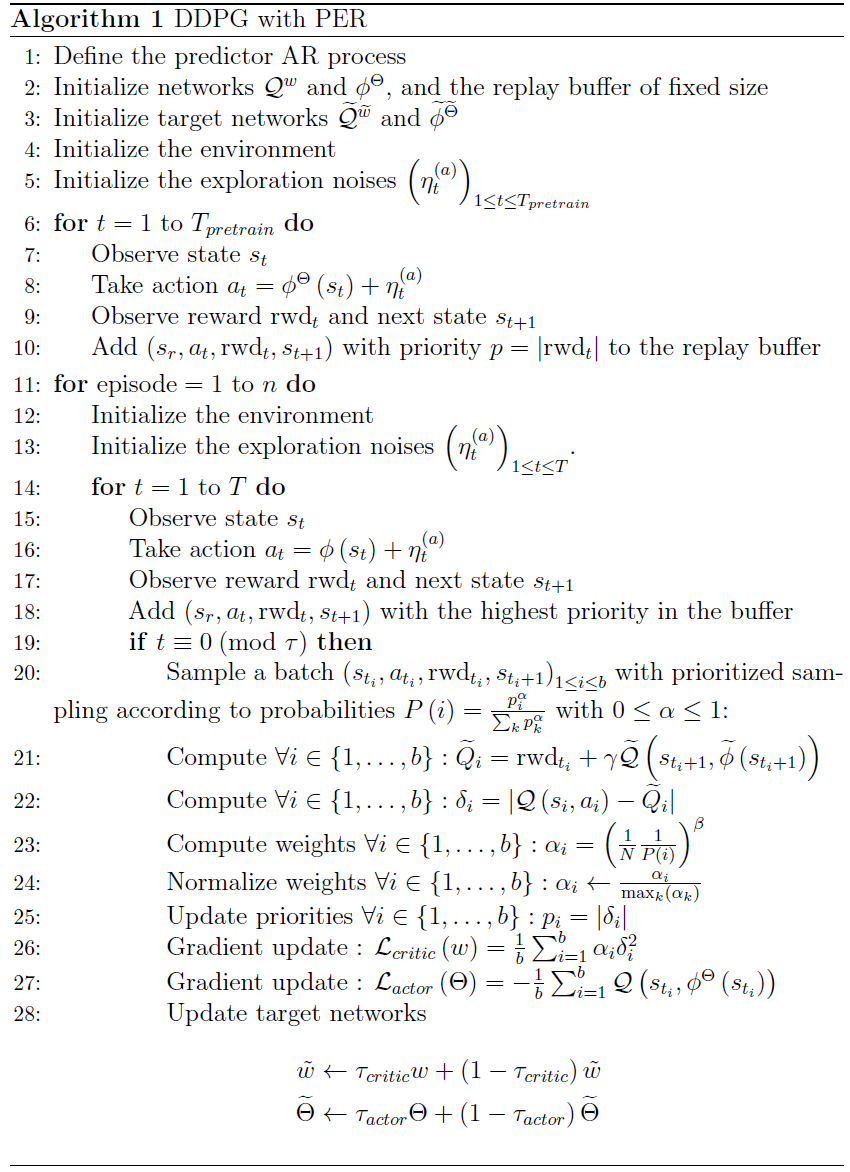

In [6]:
Transition = namedtuple(
    "Transition", ("state", "action", "reward", "next_state", "dones")
)

GAMMA = 0.99  # discount factor
TAU_ACTOR = 1e-1  # soft update of the actor target parameters
TAU_CRITIC = 1e-3  # soft update of critic target parameters
LR_ACTOR = 1e-4  # learning rate of the actor
LR_CRITIC = 1e-3  # learning rate of the critic
WEIGHT_DECAY_actor = 0  # L2 weight decay of the actor
WEIGHT_DECAY_critic = 1e-2  # L2 weight decay of the critic
BATCH_SIZE = 64  # minibatch size
BUFFER_SIZE = int(1e6)  # replay buffer size
PRETRAIN = 64  # number of pretraining steps (must be greater than BATCH_SIZE)  #noqa
MAX_STEP = 100  # number of steps in an episode
WEIGHTS = "weights/"  # path to the repository where to save the models' weights
FC1_UNITS_ACTOR = 16  # Number of nodes in first hidden layer
FC2_UNITS_ACTOR = 8  # Number of nodes in second hidden layer
FC1_UNITS_CRITIC = 64  # Number of nodes in first hidden layer of the critic network
FC2_UNITS_CRITIC = 32  # Number of nodes in second hidden layer of the critic network
DECAY_RATE = 0  # Decay rate of the exploration noise
EXPLORE_STOP = 1e-3  # Final exploration probability


def optimal_f(p, pi, lambd=0.5, Gamma=0.3, cost="trade_l2"):
    """
    Description
    --------------
    Optimal solution for cost models with l2, l1 or no trading costs.
    Parameters
    --------------
    p     : Float, the next signal value.
    pi    : Float, the current position.
    lambd : Float > 0, Parameter of the cost model.
    Gamma   : Float > 0, Parameter of our model defining the trading cost.
    cost  : String in ['none', 'trade_l1', 'trade_l2'], cost model.
    Returns
    --------------
    Float, The optimal solution evaluation (which is the next position).
    """

    if cost == "trade_0":
        return p / (2 * lambd) - pi

    elif cost == "trade_l2":
        return p / (2 * (lambd + Gamma)) + Gamma * pi / (lambd + Gamma) - pi

    elif cost == "trade_l1":
        if p <= -Gamma + 2 * lambd * pi:
            return (p + Gamma) / (2 * lambd) - pi

        elif -Gamma + 2 * lambd * pi < p < Gamma + 2 * lambd * pi:
            return 0

        elif p >= Gamma + 2 * lambd * pi:
            return (p - Gamma) / (2 * lambd) - pi


# Vectorizing the optimal solution.
optimal_f_vec = np.vectorize(optimal_f, excluded=set(["pi", "lambd", "Gamma", "cost"]))


def optimal_max_pos(p, pi, thresh, max_pos):
    """
    Description
    --------------
    Function with the shape of the optimal solution for MaxPos cost model with l1 trading
    cost.
    Parameters
    --------------
    p       : Float, the next signal value.
    pi      : Float, the current position.
    thresh  : Float > 0, threshold of the solution in the infinite horizon case.
    max_pos : Float > 0, maximum allowed position.
    Returns
    --------------
    Float, The function evaluation (which is the next trade).
    """

    if abs(p) < thresh:
        return 0
    elif p >= thresh:
        return max_pos - pi
    elif p <= -thresh:
        return -max_pos - pi


# Vectorizing.
optimal_f_vec = np.vectorize(optimal_f, excluded=set(["pi", "lambd", "Gamma", "cost"]))
optimal_max_pos_vec = np.vectorize(
    optimal_max_pos, excluded=set(["pi", "thresh", "max_pos"])
)


class OUNoise:
    """
    Class of the OU exploration noise.
    """

    def __init__(self, mu=0.0, theta=0.1, sigma=0.1):
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = self.mu

    def sample(self, truncate=False, max_pos=2, position=0, action=0):
        x = self.state
        if truncate:
            from scipy.stats import truncnorm

            m = -max_pos - position - action - (1 - self.theta) * x
            M = max_pos - position - action - (1 - self.theta) * x
            x_a, x_b = m / self.sigma, M / self.sigma
            X = truncnorm(x_a, x_b, scale=self.sigma)
            dx = self.theta * (self.mu - x) + X.rvs()
            self.state = x + dx
            return self.state

        else:
            dx = self.theta * (self.mu - x) + self.sigma * np.random.randn()
            self.state = x + dx
            return self.state


class Agent:
    def __init__(
        self,
        gamma=GAMMA,
        max_size=BUFFER_SIZE,
        max_step=MAX_STEP,
        memory_type="uniform",
        alpha=0.6,
        beta0=0.4,
        epsilon=1e-8,
        sliding="oldest",
        batch_size=BATCH_SIZE,
        theta=1.0,
        sigma=1.0,
    ):
        """
        Description
        -------------
        Constructor of class Agent
        Parameters & Arguments
        -------------
        gamma       : Float < 1 (typically 0.99), the discount factor.
        max_size    : Int, the maximum size of the memory buffer.
        max_step    : Int, number of steps in an episode.
        memory_type : String in ['uniform', 'prioritized'] type of experience replay to
                      use.
        alpha       : Float in [0, 1], power of prioritization to use (used only with
                      prioritized experience replay).
        beta0       : Float in [0, 1] that gets annealed to 1 during training because of
                      the bias introduced by priority sampling (used only with prioritized
                      experience replay).
        epsilon     : Float > 0 very small, introduced in priority estimation to ensure no
                      transition has 0 priority.
        sliding     : String in ['oldest', 'random'], when the tree gets saturated and a
                      new experience comes up.
                            - 'oldest' : Oldest leaves are the first to be changed.
                            - 'random' : Random leaves are changed.
        batch_size  : Int, the training batch size.
        theta       : Float, Noise parameter.
        sigma       : Float, Noise parameter.
        memory      : Memory object, the memory buffer.
        noise       : OUNoise object, the exploration noise which is an Ornstein-Uhlenbeck
                      process.
        """

        assert 0 <= gamma <= 1, "Discount factor gamma must be in [0, 1]"
        assert memory_type in [
            "uniform",
            "prioritized",
            "per_intervals",
        ], "memory must be in ['uniform', 'prioritized']"
        self.gamma = gamma
        self.max_size = max_size
        self.memory_type = memory_type
        self.epsilon = epsilon

        if memory_type == "uniform":
            self.memory = Memory(max_size=max_size)

        elif memory_type == "prioritized":
            self.memory = PrioritizedMemory(max_size=max_size, sliding=sliding)

        self.max_step = max_step
        self.alpha = alpha
        self.beta0 = beta0
        self.batch_size = batch_size
        self.noise = OUNoise(theta=theta, sigma=sigma)

        # Actor Networks initialized to None
        self.actor_local = None
        self.actor_target = None

        # Critic Networks initialized to None
        self.critic_local = None
        self.critic_target = None

    def reset(self):
        """
        Description
        -------------
        Reset the exploration noise.
        Parameters
        -------------
        Returns
        -------------
        """

        self.noise.reset()

    def step(self, state, action, reward, next_state, done, pretrain=False):
        """
        Description
        -------------
        Save the experience (state, action, reward, next_state, not done) in the replay
        buffer.
        Parameters
        -------------
        state      : 2-tuple of Floats: - state[0]: pi, the current position.
                                        - state[1]: p, the next value of the signal.
        action     : Float, the action taken (which is the next position).
        reward     : Float, the computed reward.
        next_state : 2-tuple of Floats representing the next state.
        done       : Boolean, whether the episode is over or not (I'm not sure if we
                     should only consider time limit as the finishing condition).
        pretrain   : Boolean, whethen we are in a pretraining phase or not.
        Returns
        -------------
        """

        # We use Pytorch tensors for further use in the pipeline.
        state_mb = torch.tensor([state], dtype=torch.float)
        action_mb = torch.tensor([[action]], dtype=torch.float)
        reward_mb = torch.tensor([[reward]], dtype=torch.float)
        next_state_mb = torch.tensor([next_state], dtype=torch.float)
        not_done_mb = torch.tensor([[not done]], dtype=torch.float)

        if self.memory_type == "uniform":
            self.memory.add(
                (state_mb, action_mb, reward_mb, next_state_mb, not_done_mb)
            )

        # During pretraining, the just initialized critic network is likely to output
        # near 0 values, so we will assume the TD error to be equal to the reward.
        elif self.memory_type == "prioritized":
            priority = (
                (abs(reward) + self.epsilon) ** self.alpha
                if pretrain
                else self.memory.highest_priority()
            )
            # Add (transition, leaf) to the buffer.
            self.memory.add(
                (state_mb, action_mb, reward_mb, next_state_mb, not_done_mb), priority
            )

    def act(self, state, noise=True, explore_probability=1, truncate=False, max_pos=2):
        """
        Description
        -------------
        Act in an exploratory fashion by adding the noise.
        Parameters
        -------------
        state               : 2-tuple of Floats:
                              - state[0]: pi, the current position.
                              - state[1]: p, the next value of the signal.
        noise               : Boolean, whether to add exploratory noise or not.
        explore_probability : Float, decaying parameter that controls the noise magnitude.
        truncate            : Boolean, truncate the noise sample such that the position
                              remains between -MaxPos and MaxPos.
        max_pos             : Float > 0, truncate the positions between -MaxPos and
                              MaxPos.
        Returns
        -------------
        Float, the clipped action (trade) to be taken.
        """

        position = state[1]
        state = torch.tensor([state], dtype=torch.float)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).data.numpy()

        self.actor_local.train()
        if noise:
            noise_sample = self.noise.sample(
                truncate=truncate,
                max_pos=max_pos,
                position=position,
                action=float(action),
            )
            action += explore_probability * noise_sample

        return float(action)

    def soft_update(self, local_model, target_model, tau):
        """
        Description
        -------------
        According to https://arxiv.org/abs/1509.02971
        Perform a soft target update of weights theta of the target_network using those
        theta_prime of the local network: theta_prime = tau*theta + (1 - tau)*theta_prime
        Parameters
        -------------
        local_model  : Actor or Critic local network.
        target_model : Actor or Critic target network.
        tau          : 0 < tau < 1
        Returns
        -------------
        Float, the clipped action to be taken (a.k.a the new position).
        """

        for target_param, local_param in zip(
            target_model.parameters(), local_model.parameters()
        ):
            target_param.data.copy_(
                tau * local_param.data + (1.0 - tau) * target_param.data
            )

    def pretrain(self, env, total_steps=PRETRAIN):
        """
        Description
        -------------
        Pretrain the agent to partially fill the replay buffer.
        Parameters
        -------------
        env : Environment object, it serves as the environment of training for the agent.
        total_steps : Int, number of pretraining steps (must be greater than BATCH_SIZE).
        Returns
        -------------
        """

        env.reset()
        with torch.no_grad():
            for i in range(total_steps):
                state = env.get_state()
                action = self.act(
                    state, truncate=(not env.squared_risk), max_pos=env.max_pos
                )
                reward = env.step(action)
                next_state = env.get_state()
                done = env.done
                self.step(state, action, reward, next_state, done, pretrain=True)
                if done:
                    env.reset()

    def train(
        self,
        env,
        total_episodes=100,
        tau_actor=TAU_ACTOR,
        tau_critic=TAU_CRITIC,
        lr_actor=LR_ACTOR,
        lr_critic=LR_CRITIC,
        weight_decay_actor=WEIGHT_DECAY_actor,
        weight_decay_critic=WEIGHT_DECAY_critic,
        total_steps=PRETRAIN,
        weights=WEIGHTS,
        freq=50,
        fc1_units_actor=FC1_UNITS_ACTOR,
        fc2_units_actor=FC2_UNITS_ACTOR,
        fc1_units_critic=FC1_UNITS_CRITIC,
        fc2_units_critic=FC2_UNITS_CRITIC,
        decay_rate=DECAY_RATE,
        explore_stop=EXPLORE_STOP,
        tensordir="runs/",
        learn_freq=50,
        plots=False,
        pi=0.5,
        lambd=None,
        Gamma=None,
        phi=None,
        thresh=3,
        mile=50,
        progress="tqdm_notebook",
    ):
        """
        Description
        -------------
        Train the agent for a total number of episodes.
        Parameters
        -------------
        env                 : Environment object, it serves as the training environment
                              for the agent.
        total_episodes      : Int, total number of training episodes.
        tau_actor           : 0 < Float < 1, soft update parameter of the actor.
        tau_critic          : 0 < Float < 1, soft update parameter of the critic.
        lr_actor            : Float, learning rate of the actor network.
        lr_critic           : Float, learning rate of the critic network.
        weight_decay_actor  : Float, L2 weight decay of the actor network.
        weight_decay_critic : Float, L2 weight decay of the critic network.
        total_steps         : Int, number of pretraining steps (must be greater than
                              BATCH_SIZE).
        weights             : String, path to the repository where to save the models'
                              weights.
        freq                : Int, number of episodes between two saved models.
        fc1_units_actor     : Int, number of nodes in the first hidden layer of the actor
                              network.
        fc2_units_actor     : Int, number of nodes in the second hidden layer of the actor
                              network.
        fc1_units_critic    : Int, number of nodes in the first hidden layer of the critic
                              network.
        fc2_units_critic    : Int, number of nodes in the second hidden layer of the
                              critic network.
        decay_rate          : Float, the decay rate of exploration noise.
        explore_stop        : Float, the final exploration noise magnitude.
        tensordir           : String, path to write tensorboard scalars.
        learn_freq          : Int, each time (number_steps%learn_freq == 0), we make a
                              training step.
        plots               : Boolean, whether to plot the shape of the function at the
                              end of each episode or not.
        pi                  : Float, only used when plots is True. The plot is done by
                              fixing pi and moving p between -4 and 4.
        lambd               : Float or None, only used when plots is True. The lambda
                              parameter of the function to plot against the models.
                              If None, lambd will be the lambd parameter of the
                              environment env.
        Gamma                 : Float or None, only used when plots is True. The Gamma
                              parameter of the function to plot against the models.
                              If None, lambd will be the lambd parameter of the
                              environment env.
        thresh              : Float > 0, threshold of the solution in the infinite horizon
                              case.
        Returns
        -------------
        """

        # Creare folder where to store the Actor weights.
        if not os.path.isdir(weights):
            os.mkdir(weights)

        # Set the summary writer of tensorboard
        writer = SummaryWriter(log_dir=tensordir)

        if plots:
            _ = plt.figure(figsize=(15, 10))
            range_values = np.arange(-4, 4, 0.01)
            signal_zeros = torch.tensor(
                np.vstack((range_values, np.zeros(len(range_values)))).T,
                dtype=torch.float,
            )
            signal_ones_pos = torch.tensor(
                np.vstack((range_values, 0.5 * np.ones(len(range_values)))).T,
                dtype=torch.float,
            )
            signal_ones_neg = torch.tensor(
                np.vstack((range_values, -0.5 * np.ones(len(range_values)))).T,
                dtype=torch.float,
            )
            if Gamma is None:
                Gamma = env.Gamma

            if lambd is None:
                lambd = env.lambd

            if env.squared_risk:
                result1 = optimal_f_vec(
                    signal_ones_neg[:, 0].numpy(),
                    -pi,
                    lambd=lambd,
                    Gamma=Gamma,
                    cost=env.cost,
                )
                result2 = optimal_f_vec(
                    signal_zeros[:, 0].numpy(), 0, lambd=lambd, Gamma=Gamma, cost=env.cost
                )
                result3 = optimal_f_vec(
                    signal_ones_pos[:, 0].numpy(),
                    pi,
                    lambd=lambd,
                    Gamma=Gamma,
                    cost=env.cost,
                )

            else:
                result1 = optimal_max_pos_vec(
                    signal_ones_neg[:, 0].numpy(), -pi, thresh, env.max_pos
                )
                result2 = optimal_max_pos_vec(
                    signal_zeros[:, 0].numpy(), 0, thresh, env.max_pos
                )
                result3 = optimal_max_pos_vec(
                    signal_ones_pos[:, 0].numpy(), pi, thresh, env.max_pos
                )

        # Define Actor local and target networks
        self.actor_local = Actor(
            env.state_size, fc1_units=fc1_units_actor, fc2_units=fc2_units_actor
        )
        self.actor_target = Actor(
            env.state_size, fc1_units=fc1_units_actor, fc2_units=fc2_units_actor
        )

        # Define the optimizer and its learning rate scheduler for the Actor networks
        actor_optimizer = optim.Adam(
            self.actor_local.parameters(), lr=lr_actor, weight_decay=weight_decay_actor
        )
        actor_lr_scheduler = lr_scheduler.StepLR(
            actor_optimizer, step_size=mile * 100, gamma=0.5
        )

        # Define Actor local and target networks
        self.critic_local = Critic(
            env.state_size, fcs1_units=fc1_units_critic, fc2_units=fc2_units_critic
        )
        self.critic_target = Critic(
            env.state_size, fcs1_units=fc1_units_critic, fc2_units=fc2_units_critic
        )

        # Define the optimizer and its learning rate scheduler for the Critic networks
        critic_optimizer = optim.Adam(
            self.critic_local.parameters(),
            lr=lr_critic,
            weight_decay=weight_decay_critic,
        )
        critic_lr_scheduler = lr_scheduler.StepLR(
            critic_optimizer, step_size=mile * 100, gamma=0.5
        )

        # Save the initialized model
        model_file = weights + "ddpg_1" + ".pth"
        torch.save(self.actor_local.state_dict(), model_file)
        # print('\nSaved model to ' + model_file + '\n')

        # Initialize containers to add some useful information about training (useful to
        # visualize with tensorboard)
        mean_rewards = deque(maxlen=10)
        cum_rewards = []
        actor_losses = deque(maxlen=10)
        critic_losses = deque(maxlen=10)

        # Reset counting the nodes of the SumTree when using Prioritized Experience
        # Replay.
        Node.reset_count()
        # Pretraining to partially fill the replay buffer.
        self.pretrain(env, total_steps=total_steps)
        i = 0
        # exploration_probability = 1
        N_train = total_episodes * env.T // learn_freq
        beta = self.beta0
        self.reset()
        n_train = 0

        range_total_episodes = range(total_episodes)
        # setup progress bar
        if progress == "tqdm_notebook":
            from tqdm import tqdm_notebook

            range_total_episodes = tqdm_notebook(list(range_total_episodes))
            progress_bar = range_total_episodes
        elif progress == "tqdm":
            from tqdm import tqdm

            range_total_episodes = tqdm(list(range_total_episodes))
            progress_bar = range_total_episodes
        else:
            progress_bar = None

        for episode in range_total_episodes:
            # start_time = time()
            episode_rewards = []
            env.reset()
            state = env.get_state()
            done = env.done
            train_iter = 0
            # Environment Exploration phase
            while not done:
                explore_probability = explore_stop + (1 - explore_stop) * np.exp(
                    -decay_rate * i
                )
                action = self.act(
                    state,
                    truncate=(not env.squared_risk),
                    max_pos=env.max_pos,
                    explore_probability=explore_probability,
                )
                reward = env.step(action)
                writer.add_scalar("State/signal", state[0], i)
                writer.add_scalar("Signal/position", state[1], i)
                writer.add_scalar("Signal/action", action, i)
                next_state = env.get_state()
                done = env.done
                self.step(state, action, reward, next_state, done)
                state = next_state
                episode_rewards.append(reward)
                i += 1
                train_iter += 1
                if done:
                    self.reset()
                    total_reward = np.sum(episode_rewards)
                    mean_rewards.append(total_reward)
                    if (episode > 0) and (episode % 5 == 0):
                        mean_r = np.mean(mean_rewards)
                        cum_rewards.append(mean_r)
                        writer.add_scalar("Reward & Loss/reward", mean_r, episode)
                        writer.add_scalar(
                            "Reward & Loss/actor_loss", np.mean(actor_losses), episode
                        )
                        writer.add_scalar(
                            "Reward & Loss/critic_loss", np.mean(critic_losses), episode
                        )

                # Learning phase
                if train_iter % learn_freq == 0:
                    n_train += 1
                    if self.memory_type == "uniform":
                        # Sample a batch of experiences :
                        # (state, action, reward, next_state, done)
                        transitions = self.memory.sample(self.batch_size)
                        batch = Transition(*zip(*transitions))
                        states_mb = torch.cat(batch.state)
                        actions_mb = torch.cat(batch.action)
                        rewards_mb = torch.cat(batch.reward)
                        next_states_mb = torch.cat(batch.next_state)
                        dones_mb = torch.cat(batch.dones)

                    elif self.memory_type == "prioritized":
                        # Sample a batch of experiences :
                        # (state, action, reward, next_state, done)
                        transitions, indices = self.memory.sample(self.batch_size)
                        batch = Transition(*zip(*transitions))
                        states_mb = torch.cat(batch.state)
                        actions_mb = torch.cat(batch.action)
                        rewards_mb = torch.cat(batch.reward)
                        next_states_mb = torch.cat(batch.next_state)
                        dones_mb = torch.cat(batch.dones)

                    # Update local Critic network
                    # Use target Actor to compute the next actions to take at the sampled
                    # next states
                    actions_next = self.actor_target(next_states_mb)
                    # Use target Critic to compute the Q values of the sampled
                    # (next_states, actions)
                    Q_targets_next = self.critic_target(next_states_mb, actions_next)
                    Q_targets = rewards_mb + (
                        self.gamma * Q_targets_next * dones_mb
                    )  # Compute target Q values
                    # Compute expected Q values with the local Critic network
                    Q_expected = self.critic_local(states_mb, actions_mb)
                    # Compute the TD errors (needed to update priorities when using
                    # Prioritized replay, and also to compute the loss)
                    td_errors = F.l1_loss(Q_expected, Q_targets, reduction="none")
                    # Update the priorities of experiences in the sampled batch when
                    # Prioritized Experience Replay is used
                    if self.memory_type == "prioritized":
                        # Sum of all priorities.
                        sum_priorities = self.memory.sum_priorities()
                        # Sampling probabilities.
                        probabilities = (
                            self.memory.retrieve_priorities(indices) / sum_priorities
                        ).reshape((-1, 1))
                        # Importance sampling weights.
                        is_weights = torch.tensor(
                            1 / ((self.max_size * probabilities) ** beta),
                            dtype=torch.float,
                        )
                        # Normalize the importance sampling weights.
                        is_weights /= is_weights.max()
                        # Update parameter beta.
                        beta = (1 - self.beta0) * (n_train / N_train) + self.beta0
                        for i_enum, index in enumerate(indices):
                            # Update the priorities of the sampled experiences.
                            self.memory.update(
                                index,
                                (abs(float(td_errors[i_enum].data)) + self.epsilon)
                                ** self.alpha,
                            )

                        # Compute Critic loss function with bias correction.
                        critic_loss = (is_weights * (td_errors ** 2)).mean() / 2

                    elif self.memory_type == "uniform":
                        # Compute Critic loss function.
                        critic_loss = (td_errors ** 2).mean() / 2

                    # Store the current Critic loss value.
                    critic_losses.append(critic_loss.data.item())

                    # Minimize the Critic loss
                    critic_optimizer.zero_grad()
                    critic_loss.backward()
                    # Clip the gradient to avoid taking huge steps in the gradient update
                    torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 0.1)
                    critic_optimizer.step()
                    critic_lr_scheduler.step()

                    # Update local Actor network
                    # Compute Actor loss which comes from the Off-Policy Deterministic
                    # Policy gradient theorem,
                    # see http://proceedings.mlr.press/v32/silver14.pdf and https://arxiv.org/abs/1509.02971  # noqa
                    actions_pred = self.actor_local(states_mb)
                    actor_loss = -self.critic_local(states_mb, actions_pred).mean()
                    actor_losses.append(actor_loss.data.item())

                    # Minimize the Actor loss
                    actor_optimizer.zero_grad()
                    actor_loss.backward()
                    # Clip the gradient to avoid taking huge steps in the gradient update
                    torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 0.1)
                    actor_optimizer.step()
                    actor_lr_scheduler.step()

                    # Update Critic and Actor target Networks
                    self.soft_update(self.critic_local, self.critic_target, tau_critic)
                    self.soft_update(self.actor_local, self.actor_target, tau_actor)

            # Plot the shape of the function and a function with approximately optimal
            # shape (regarding the cumulative reward) found by a gridsearch over lambd and
            # Gamma parameters
            if plots:
                plt.clf()
                self.actor_local.eval()
                with torch.no_grad():
                    plt.subplot(2, 3, 1)
                    plt.plot(
                        signal_ones_neg[:, 0].numpy(),
                        self.actor_local(signal_ones_neg)[:, 0].data.numpy(),
                        label="model",
                    )
                    plt.plot(signal_ones_neg[:, 0].numpy(), result1, label="optimal")
                    plt.xlim(-4, 4)
                    plt.ylim(-4, 4)
                    plt.legend()

                    plt.subplot(2, 3, 2)
                    plt.plot(
                        signal_zeros[:, 0].numpy(),
                        self.actor_local(signal_zeros)[:, 0].data.numpy(),
                        label="model",
                    )
                    plt.plot(signal_zeros[:, 0].numpy(), result2, label="optimal")
                    plt.xlim(-4, 4)
                    plt.ylim(-4, 4)
                    plt.legend()

                    plt.subplot(2, 3, 3)
                    plt.plot(
                        signal_ones_pos[:, 0].numpy(),
                        self.actor_local(signal_ones_pos)[:, 0].data.numpy(),
                        label="model",
                    )
                    plt.plot(signal_ones_pos[:, 0].numpy(), result3, label="optimal")
                    plt.xlim(-4, 4)
                    plt.ylim(-4, 4)
                    plt.legend()

                    plt.subplot(2, 3, 4)
                    sns.distplot(states_mb[:, 0])

                display.clear_output(wait=True)
                if progress_bar is not None:
                    display.display(progress_bar)
                display.display(plt.gcf())
                sleep(0.0001)
                self.actor_local.train()

            # Save the Actor network weights after a number of episodes each time
            if (episode % freq) == 0:
                model_file = weights + "ddpg_" + str(episode) + ".pth"
                torch.save(self.actor_local.state_dict(), model_file)
                # print('\nSaved model to ' + model_file + '\n')

        writer.export_scalars_to_json("./all_scalars.json")
        writer.close()

## Evaluation et visualisation des résultats

Les performances des agents sont mesur ees selon les resultats sur
un jeu de donn ́ees test compos ́ees de 10 environnements de pas $T = 5000$

In [7]:
def test_models(
    path_weights, env, fc1_units=16, fc2_units=8, random_state=1024, n_episodes=100
):
    """
    Description
    ---------------
    Evaluate saved models on a number of environments simulated with a fixed random state.
    The evaluation is the average score over the total number of test episodes.
    Parameters
    ---------------
    path_weights    : String, path to the saved training weights.
    env : Object of class Environment, the evaluation environment (It should be the same
          as the training environment).
    fc1_units       : Int, number of nodes in the first layer of the network.
    fc2_units       : Int, number of nodes in the second layer of the network.
    random_state : Int, a fixed random state to evaluate all models on the same episodes.
    n_episodes      : Int, the total number of evaluation episodes.
    Returns
    ---------------
    scores          : Dict, - keys   : training iteration of the saved model.
                            - values : average score over the evaluation episodes.
    scores_episodes : Dict, - keys   : training iteration of the saved model.
                            - values : Dict, - keys   : index of the evaluation episode.
                                             - values : score over the evaluation episode.
    scores_cumsum   : Dict, - keys   : training iteration of the saved model.
                            - values : Dict,
                                - keys   : index of the evaluation episode.
                                - values : cumulative sum of the reward at each time step
                                           per episode.
    pnls            : Dict, - keys   : training iteration of the saved model.
                            - values : Dict, - keys   : index of the evaluation episode.
                                             - values : pnl per episode.
    positions       : Dict, - keys   : training iteration of the saved model.
                            - values : Dict, - keys   : index of the evaluation episode.
                                             - values : positions per episode.
    """

    models_names = os.listdir(path_weights)
    if ".ipynb_checkpoints" in models_names:
        models_names.remove(".ipynb_checkpoints")

    agent = Agent()
    rng = np.random.RandomState(random_state)
    random_states = rng.randint(0, int(1e6), size=n_episodes)
    scores = {}
    scores_episodes = {}
    scores_cumsum = {}
    positions = {}
    pnls = {}
    for model_name in models_names:
        # print(model_name)
        state_dict = torch.load(path_weights + model_name)
        model = Actor(env.state_size, fc1_units=fc1_units, fc2_units=fc2_units)
        model.load_state_dict(state_dict)
        score, score_episode, score_cumsum, pnl, position = env.test(
            agent, model, total_episodes=n_episodes, random_states=random_states
        )
        scores[int(model_name[5:][:-4])] = score
        scores_episodes[int(model_name[5:][:-4])] = score_episode
        scores_cumsum[int(model_name[5:][:-4])] = score_cumsum
        positions[int(model_name[5:][:-4])] = position
        pnls[int(model_name[5:][:-4])] = pnl
        # print('Average score : %.2f' % score)
        # print('\n')

    return scores, scores_episodes, scores_cumsum, pnls, positions


def plot_bars(scores):
    """
    Description
    ---------------
    Bar plot of the evaluation score across the models. Note that the optimal model is indexed by 0
    Parameters
    ---------------
    scores : First return of test_models function (see its doc for more details)
    Returns
    ---------------
    """

    scores = dict(sorted(scores.items()))

    _ = plt.figure(figsize=(30, 10))
    plt.bar(range(len(scores)), list(scores.values()), align="center")
    plt.xticks(range(len(scores)), list(scores.keys()))
    plt.title("Overview of the perfomance of each model", fontsize=20)
    plt.show()


def plot_min_max(env, models_keys, scores_episodes):
    """
    Description
    ---------------
    For each model indexed by models_keys and the optimal model, plot the min score signal
    and max score signals along with their respective scores. Note that the optimal model
    is indexed by 0
    Parameters
    ---------------
    env : Object of class Environment, the evaluation environment (It should be the same
          as the training environment).
    models_keys     : List of 5 elements containing the indices of the models to use.
    scores_episodes : Second return of test_models function (see its doc for more
                      details).
    Returns
    ---------------
    """

    _ = plt.figure(figsize=(20, 10))
    models_keys = [-1] + models_keys
    for i, model_key in enumerate(models_keys):
        score_episode = scores_episodes[model_key]
        random_state_min, random_state_max = (
            min(score_episode, key=score_episode.get),
            max(score_episode, key=score_episode.get),
        )

        env.reset(random_state=random_state_min)
        signal_min = env.signal

        env.reset(random_state=random_state_max)
        signal_max = env.signal

        plt.subplot(2, 3, i + 1)
        plt.plot(
            range(len(signal_min)),
            signal_min,
            label="min %.2f" % score_episode[random_state_min],
        )
        plt.plot(
            range(len(signal_max)),
            signal_max,
            label="max %.2f" % score_episode[random_state_max],
        )
        plt.legend()
        plt.title("model %d" % model_key)

    plt.show()


def plot_hist(model_key, scores_episodes):
    """
    Description
    ---------------
    Plot histogram of scores across the evaluation episodes of model indexed by model_key
    and compare it with the optimal model
    Parameters
    ---------------
    model_key       : Int, the index of the considered model.
    scores_episodes : Second return of test_models function (see its doc for more
                      details).
    Returns
    ---------------
    """

    _ = plt.figure(figsize=(15, 4))
    plt.subplot(121)
    sns.distplot(list(scores_episodes[model_key].values()))
    plt.title("score distribution of model %d" % model_key)

    plt.subplot(122)
    sns.distplot(list(scores_episodes[-1].values()))
    plt.title("score distribution of optimal model")

    plt.show()


def optimal_f(p, pi, lambd=0.5, Gamma=0.3, cost="trade_l2"):
    """
    Description
    --------------
    Optimal solution for cost models with l2, l1 or no trading costs.
    Parameters
    --------------
    p     : Float, the next signal value.
    pi    : Float, the current position.
    lambd : Float > 0, Parameter of the cost model.
    Gamma   : Float > 0, Parameter of our model defining the trading cost.
    cost  : String in ['none', 'trade_l1', 'trade_l2'], cost model.
    Returns
    --------------
    Float, The optimal solution evaluation (which is the next position).
    """

    if cost == "trade_0":
        return p / (2 * lambd) - pi

    elif cost == "trade_l2":
        return p / (2 * (lambd + Gamma)) + Gamma * pi / (lambd + Gamma) - pi

    elif cost == "trade_l1":
        if p <= -Gamma + 2 * lambd * pi:
            return (p + Gamma) / (2 * lambd) - pi

        elif -Gamma + 2 * lambd * pi < p < Gamma + 2 * lambd * pi:
            return 0

        elif p >= Gamma + 2 * lambd * pi:
            return (p - Gamma) / (2 * lambd) - pi


# Vectorizing the optimal solution.
optimal_f_vec = np.vectorize(optimal_f, excluded=set(["pi", "lambd", "Gamma", "cost"]))


def plot_function(
    path_weights,
    env,
    models_keys,
    fc1_units=16,
    fc2_units=8,
    low=-1,
    high=1,
    step=0.01,
    pi=0.5,
    Gamma=0.3,
    lambd=0.5,
    thresh=2,
    clip=True,
):
    """
    Description
    ---------------
    Plot the functions of each model along with the optimal function given a position and
    a range for the signal.
    Parameters
    ---------------
    path_weights    : String, path to the saved training weights.
    env : Object of class Environment, the evaluation environment (It should be the same
          as the training environment).
    models_keys     : List of 6 elements containing the indices of the models to use.
    fc1_units       : Int, number of nodes in the first layer of the network.
    fc2_units       : Int, number of nodes in the second layer of the network.
    low             : Float, minimum of the signal range.
    high            : Float, maximum of the signal range.
    step            : Float, step size along the signal range.
    pi              : Float, plot using -pi, 0 and pi.
    Gamma             : Float or None, parameter of the solution for both second and third
                                     model.
                      None  -> Only plot the myopic solution function.
                      Float -> Also plot the solution function with the given parameter
                               Gamma.
    lambd           : Float, parameter controlling the slope of the solution outside the
                      band.
    thresh          : Float>0, price threshold to make a trade.
    clip            : Boolean, whether to clip positions beyond maxpos or not.
    Returns
    ---------------
    """

    range_values = np.arange(low, high, step)
    signal_zeros = torch.tensor(
        np.vstack((range_values, np.zeros(len(range_values)))).T, dtype=torch.float
    )
    signal_ones_pos = torch.tensor(
        np.vstack((range_values, pi * np.ones(len(range_values)))).T, dtype=torch.float
    )
    signal_ones_neg = torch.tensor(
        np.vstack((range_values, -pi * np.ones(len(range_values)))).T, dtype=torch.float
    )
    if env.squared_risk:
        optimal1 = optimal_f_vec(
            signal_ones_neg[:, 0].numpy(), -pi, lambd=lambd, Gamma=Gamma, cost=env.cost
        )
        optimal2 = optimal_f_vec(
            signal_zeros[:, 0].numpy(), 0, lambd=lambd, Gamma=Gamma, cost=env.cost
        )
        optimal3 = optimal_f_vec(
            signal_ones_pos[:, 0].numpy(), pi, lambd=lambd, Gamma=Gamma, cost=env.cost
        )

    else:
        optimal1 = optimal_max_pos_vec(
            signal_ones_neg[:, 0].numpy(), -pi, thresh, env.max_pos
        )
        optimal2 = optimal_max_pos_vec(
            signal_zeros[:, 0].numpy(), 0, thresh, env.max_pos
        )
        optimal3 = optimal_max_pos_vec(
            signal_ones_pos[:, 0].numpy(), pi, thresh, env.max_pos
        )

    _ = plt.figure(figsize=(20, 30))
    for i, model_key in enumerate(models_keys):
        state_dict = torch.load(path_weights + "ddpg_" + str(model_key) + ".pth")
        model = Actor(env.state_size, fc1_units=fc1_units, fc2_units=fc2_units)
        model.load_state_dict(state_dict)
        model.eval()
        with torch.no_grad():
            if clip:
                model1 = np.clip(
                    model(signal_ones_neg)[:, 0].data.numpy(),
                    -env.max_pos + pi,
                    env.max_pos + pi,
                )
                model2 = np.clip(
                    model(signal_zeros)[:, 0].data.numpy(), -env.max_pos, env.max_pos
                )
                model3 = np.clip(
                    model(signal_ones_pos)[:, 0].data.numpy(),
                    -env.max_pos - pi,
                    env.max_pos - pi,
                )

            else:
                model1 = model(signal_ones_neg)[:, 0].data.numpy()
                model2 = model(signal_zeros)[:, 0].data.numpy()
                model3 = model(signal_ones_pos)[:, 0].data.numpy()

            plt.subplot(len(models_keys), 3, i * 3 + 1)
            plt.plot(signal_ones_neg[:, 0].numpy(), model1, label="model")
            plt.plot(signal_ones_neg[:, 0].numpy(), optimal1, label="optimal")

            plt.xlim(-4, 4)
            plt.ylim(-4, 4)
            plt.title(r"model : %d, $\pi = -%s$" % (model_key, str(pi)))
            plt.legend()

            plt.subplot(len(models_keys), 3, i * 3 + 2)
            plt.plot(signal_zeros[:, 0].numpy(), model2, label="model")
            plt.plot(signal_zeros[:, 0].numpy(), optimal2, label="optimal")

            plt.xlim(-4, 4)
            plt.ylim(-4, 4)
            plt.title(r"model : %d, $\pi = 0$" % model_key)
            plt.legend()

            plt.subplot(len(models_keys), 3, i * 3 + 3)
            plt.plot(signal_ones_pos[:, 0].numpy(), model3, label="model")
            plt.plot(signal_ones_pos[:, 0].numpy(), optimal3, label="optimal")

            plt.xlim(-4, 4)
            plt.ylim(-4, 4)
            plt.title(r"model : %d, $\pi = %s$" % (model_key, str(pi)))
            plt.legend()

    plt.show()

# Présentation des performances

## Coût linéaire et risque quadratique

$$
\textrm{rwd}_t= \pi_{t+1} p_{t+1} - \lambda \pi_{t+1}^2 - \Gamma |a_{t}|;\hspace{2mm}
\lambda, \Gamma > 0
$$

**Solution optimale approchée par** ***GridSearch***


$$ a^*\left(\pi_{t-1}, p_t \right) = \begin{cases} \frac{1}{2\widetilde{\lambda}}\left(p_t
- \widetilde{\Gamma} \right) - \pi_{t-1}; \hspace{2mm} p_t \ge \widetilde{\Gamma} +
2\widetilde{\lambda} \pi_{t-1} \\ 0 \hspace{13mm}; \hspace{2mm} -\widetilde{\Gamma} +
2\widetilde{\lambda} \pi_{t-1} \le p_t \le \widetilde{\Gamma} + 2\widetilde{\lambda}
\pi_{t-1} \\ \frac{1}{2\widetilde{\lambda}}\left( p_t + \widetilde{\Gamma} \right)-
\pi_{t-1}; \hspace{2mm} p_t \le -\widetilde{\Gamma} + 2\widetilde{\lambda} \pi_{t-1}
\end{cases} $$

 $\widetilde{\lambda}, \widetilde{\Gamma}$ sont trouvé par *GridSearch*.

**Environment**

On utilise les paramètres suivants:
$$
\begin{cases}
\rho = 0.1 \\
\sigma = 0.1 \\
T = 5000 \\
\lambda = 0.3 \\
\Gamma = 4
\end{cases}
$$

In [27]:
RHO = 0.1
SIGMA = 0.1
T = 5000
LAMBD = 0.3
GAMMA =4
GlobalSummaryWriter = 4
env = Environment(
    rho=RHO, sigma=SIGMA, T=T, lambd=LAMBD, Gamma=GAMMA,
      cost="trade_l1", #coût proportionnel
      scale_reward=1,
      squared_risk=True #avec risque quadratique
)

Le *GridSearch* permet d'estimer $\widetilde{\lambda},
\widetilde{\Gamma}$ par moyenne cumulative sur 10 épisodes.

In [28]:
%%time
import tqdm
random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)

lambds = np.linspace(0.2, 0.6, 10)
gammas = np.linspace(0.8, 1.2, 10)

# 1ère dim: lambdas; 2ème dim: gammas; 3ème dim: episodes
scores_episodes = np.empty((len(lambds), len(gammas), n_episodes))
scores = np.empty((len(lambds), len(gammas)))  # 1ère dim: lambdas; 2ème dim: gammas

for i, lambd in tqdm.tqdm_notebook(list(enumerate(lambds))):
    for j, Gamma in tqdm.tqdm_notebook(list(enumerate(gammas))):
        score, score_episode, _, _, _ = env.test_apply(
            total_episodes=n_episodes, random_states=random_states, lambd=lambd, Gamma=Gamma
        )
        scores[i, j] = score
        scores_episodes[i, j, :] = list(score_episode.values())
        # print('lambd=%.1f , Gamma=%.1f -> score=%.3f \n' % (lambd, Gamma, score))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 2min 18s


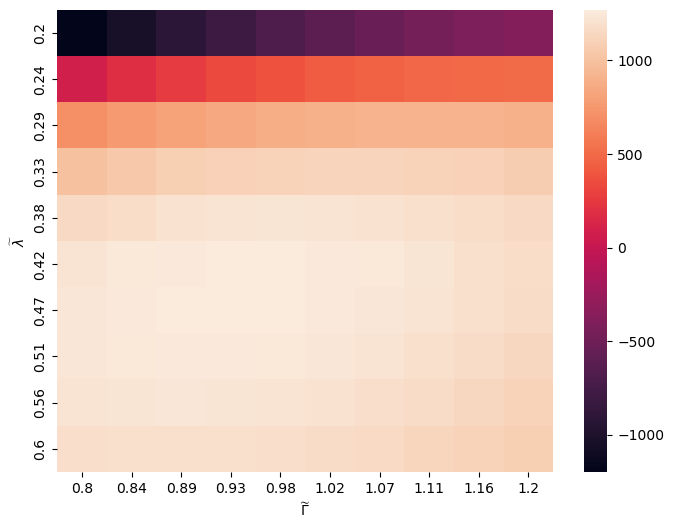

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.DataFrame(
        scores,
        index=pd.Index(np.round(lambds, 2), name=r"$\widetilde{\lambda}$"),
        columns=pd.Index(np.round(gammas, 2), name=r"$\widetilde{\Gamma}$"),
    )
)
plt.show()

In [30]:
i_max = np.argmax(scores) // scores.shape[0]
j_max = np.argmax(scores[i_max, :])

lambd_max, Gamma_max = lambds[i_max], gammas[j_max]
print("lambd_max=%.2f , Gamma_max=%.2f" % (lambd_max, Gamma_max))

lambd_max=0.47 , Gamma_max=0.93


On trouve $\widetilde{\lambda}=0.47, \widetilde{\Gamma}=0.93$

### Entraînement

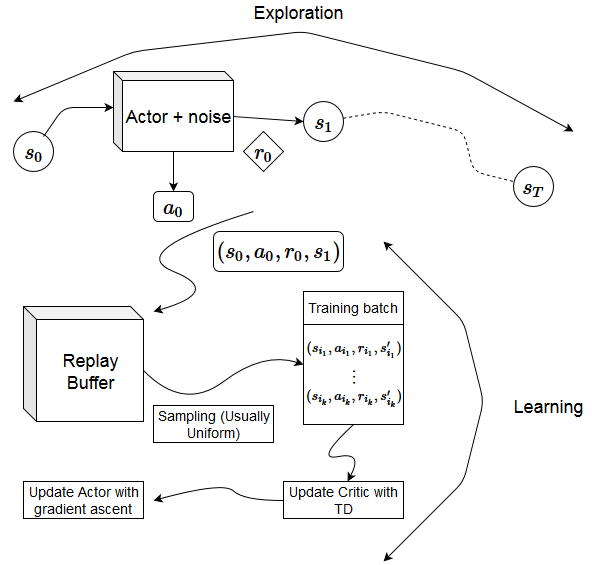

L'agent DDPG est un modèle acteur-critique. Les parties acteurs et critiques ont la même structure : 
- Une couche dense initial de taille $16$ avec activation reLU,
- Une couche dense caché de taille $16$ avec activation reLU
- Une couche linéaire de taille $1$.


Lors d'un épisode, l'agent effectue l'action $a_t = a_t^{pred} + \eta_t^{(a)}$  étant donnée sa position actuelle $\pi_t$ (initié à $\pi_0 = 0$ et le revenue prévisible $p_t$ :
$$\begin{cases}
    a_t^{pred} = \phi_\Theta(p_t,\pi_t)\\
    \eta_t^{(a)} = \theta^{expl}\eta_{t-1}^{(a)} + \sigma^{expl}\epsilon_t\\
    \eta_0^{(a)} = 0
\end{cases}$$
$\eta_t^{(a)}$ est le bruit d'exploration, qui suit un processus AR(1) avec $\epsilon_t \sim_{iid} \mathcal{N}(0,1)$, $\sigma^{explo}>0$.
L'agent explore l'environnemment avec sa politique, auquel est ajouté un bruit centré réduit. On prend $\theta^{expl} = 1, \sigma^{expl} =1$

Les experiences acquises sont mises dans un *replay buffer* de taille
$10^6$ et on utilise le  *Prioritized Experience Replay*  pour échantillonner un *batch* de taiile $512$ après chaque lot de $50$ itération.

Avant l'entraînement, un pré-entraînement est effectué pour remplir le *replay buffer* avec 1000 expériences.

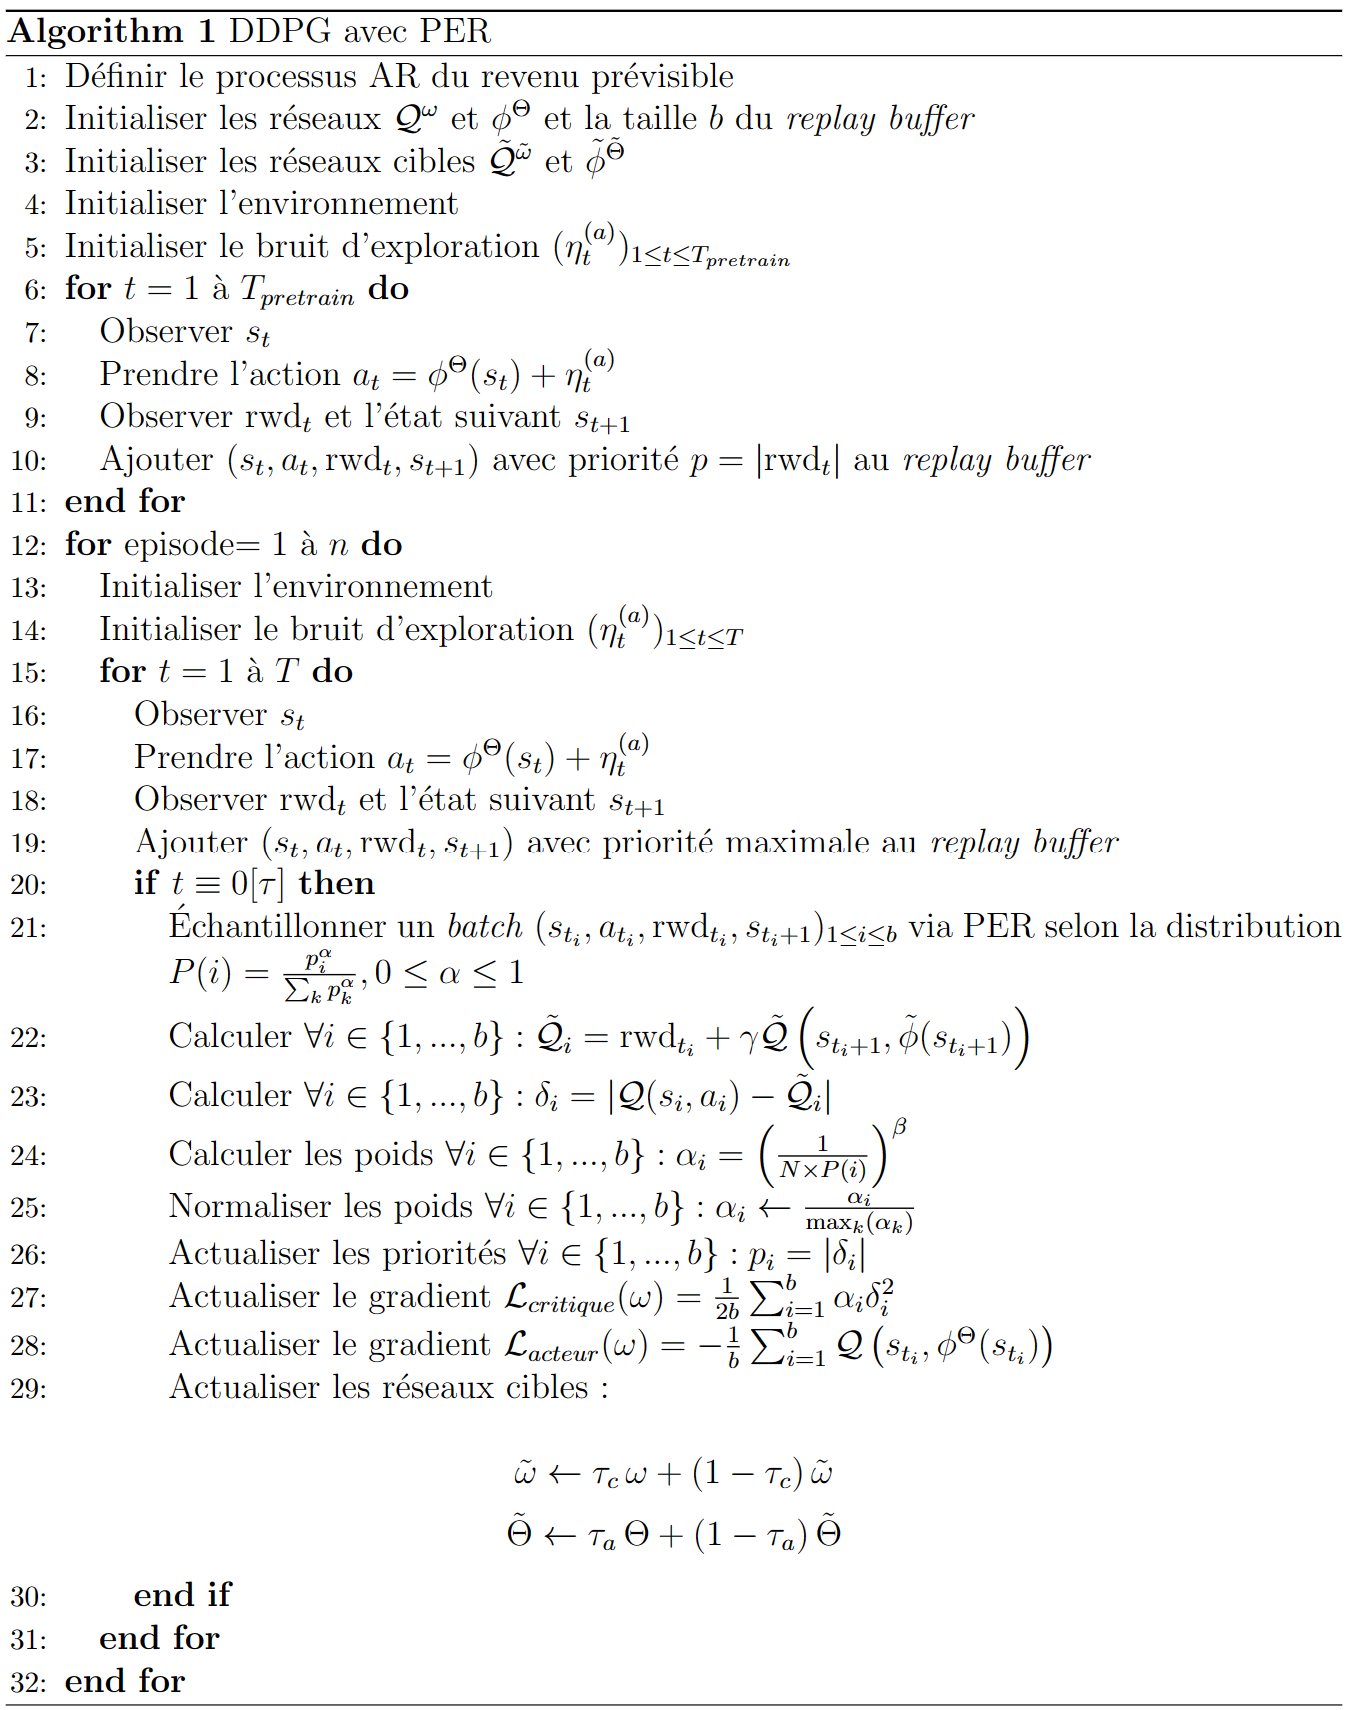

In [31]:
# Paramètres de l'agent
MAX_STEPS = 5000 #nombre de pas dans un épisode
MEMORY_TYPE = "prioritized" #ou uniform pour une mémoire uniformisée
SLIDING = "oldest" #ou "random" si on veut supprimer aléatoirement les expériences du replay buffer
BATCH_SIZE = 2 ** 9 # taille du batch
MAX_SIZE = int(1e6) # taille maximum du replay buffer

# Paramètres d'entraînement
TOTAL_EPISODES = 501
TOTAL_STEPS = 1000
FREQ = 10
LEARN_FREQ = 50
TAU_ACTOR = 0.3
TAU_CRITIC = 0.1
LR_ACTOR = 1e-3
LR_CRITIC = 1e-2
WEIGHTS_DECAY_ACTOR = 0
WEIGHTS_DECAY_CRITIC = 0
FC1_UNITS_ACTOR = 16
FC2_UNITS_ACTOR = 16
FC1_UNITS_CRITIC = 16
FC2_UNITS_CRITIC = 16

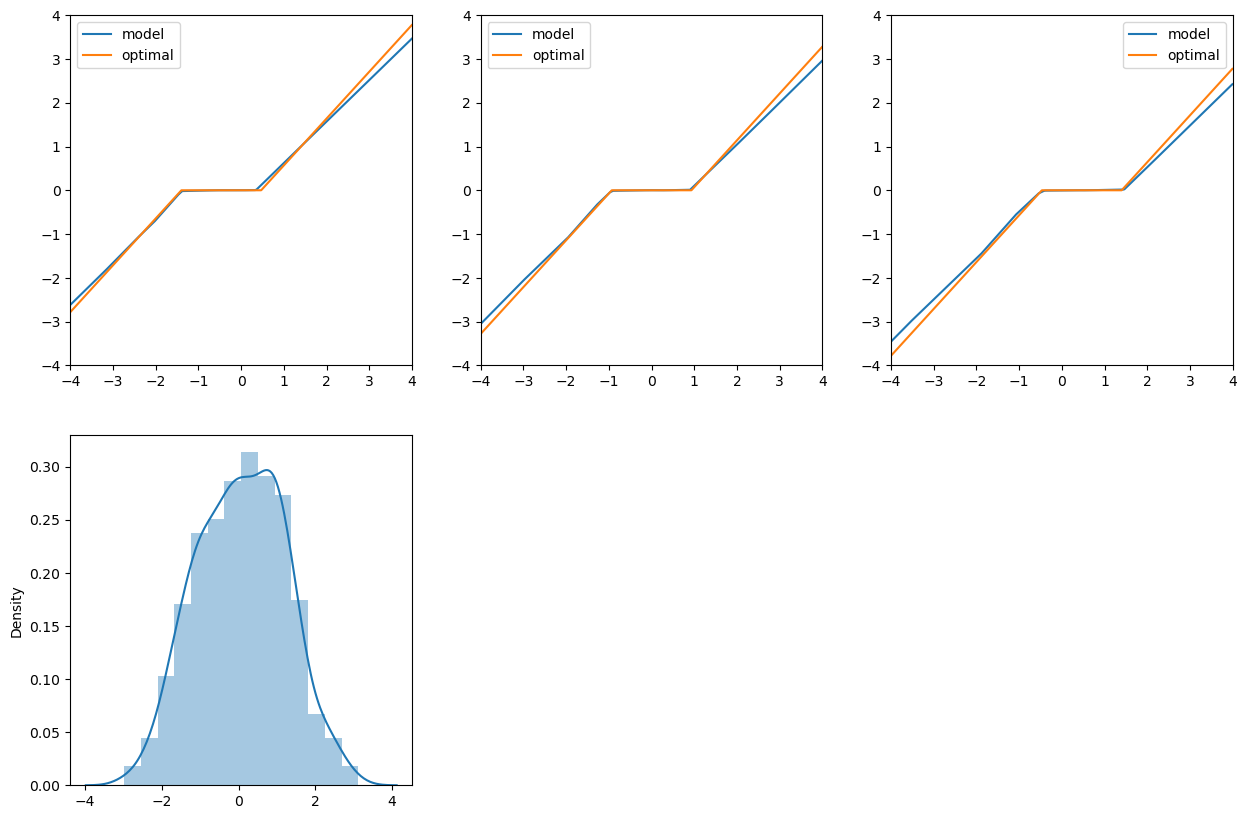

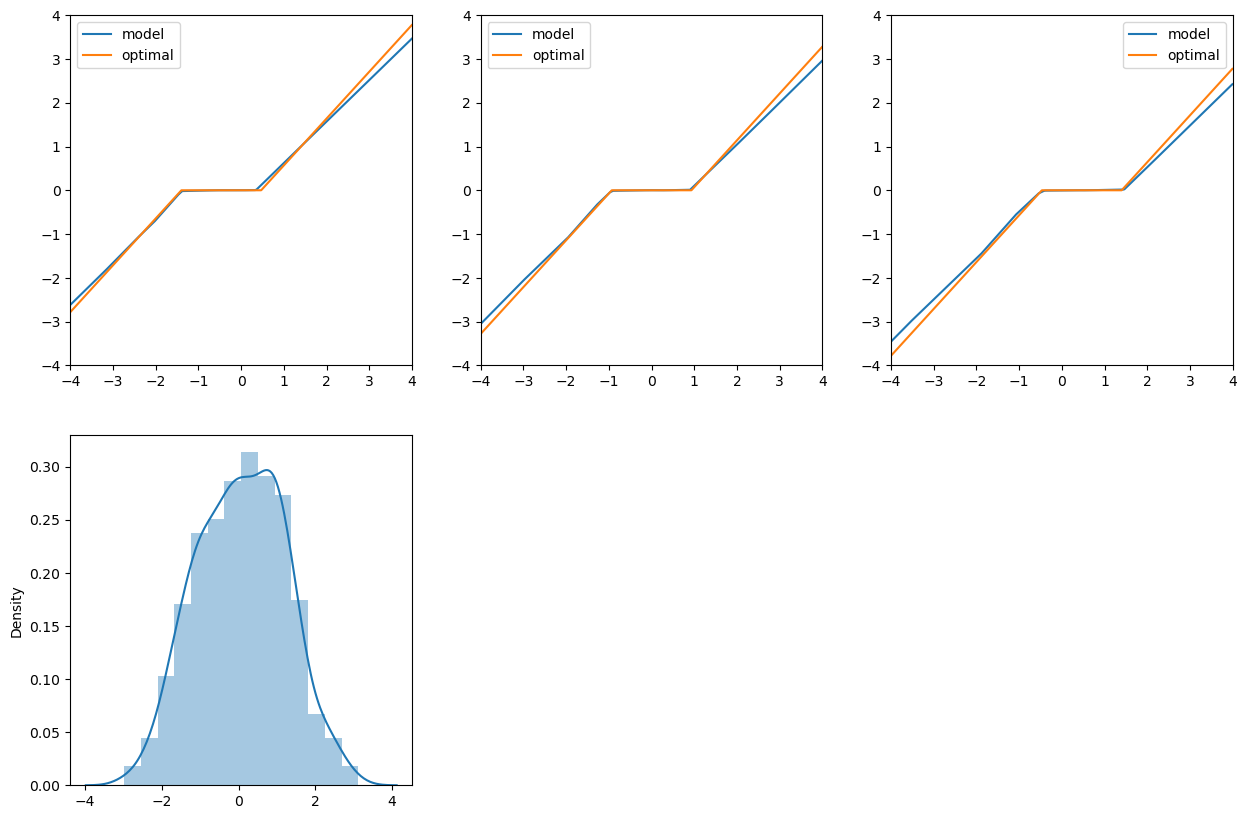

In [32]:
# %%time
agent = Agent(
    max_size=MAX_SIZE,
    max_step=MAX_STEPS,
    memory_type=MEMORY_TYPE,
    sliding=SLIDING,
    batch_size=BATCH_SIZE,
)

path = "Experiment_linear_trading_cost_true_per/"
if not os.path.exists(path + "weights/"):
    os.makedirs(path + "weights/")

agent.train(
    env=env,
    total_episodes=TOTAL_EPISODES,
    tau_actor=TAU_ACTOR,
    tau_critic=TAU_CRITIC,
    lr_actor=LR_ACTOR,
    lr_critic=LR_CRITIC,
    weight_decay_actor=WEIGHTS_DECAY_ACTOR,
    weight_decay_critic=WEIGHTS_DECAY_CRITIC,
    total_steps=TOTAL_STEPS,
    weights=path + "weights/",
    freq=FREQ,
    fc1_units_actor=FC1_UNITS_ACTOR,
    fc2_units_actor=FC2_UNITS_ACTOR,
    fc1_units_critic=FC1_UNITS_CRITIC,
    fc2_units_critic=FC2_UNITS_CRITIC,
    learn_freq=LEARN_FREQ,
    plots=True,
    lambd=lambd_max,
    Gamma=Gamma_max,
    tensordir=path + "runs/",
    mile=100,
    decay_rate=1e-6,
)

### Evaluation

On évalue les performances du modèle sut $10$ épisodes tests, et l'on compare à la solution optimale.

In [33]:
path_weights = "Experiment_linear_trading_cost_true_per/weights/"
scores, scores_episodes, scores_cumsum, pnls, positions = test_models(
    path_weights, env, n_episodes=10, fc1_units=16, fc2_units=16
)

random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)
score, score_episode, scores_cumsum_opt, pnls_opt, positions_opt = env.test_apply(
    total_episodes=n_episodes, random_states=random_states, lambd=lambd_max, Gamma=Gamma_max
)
scores[-1] = score
scores_episodes[-1] = score_episode

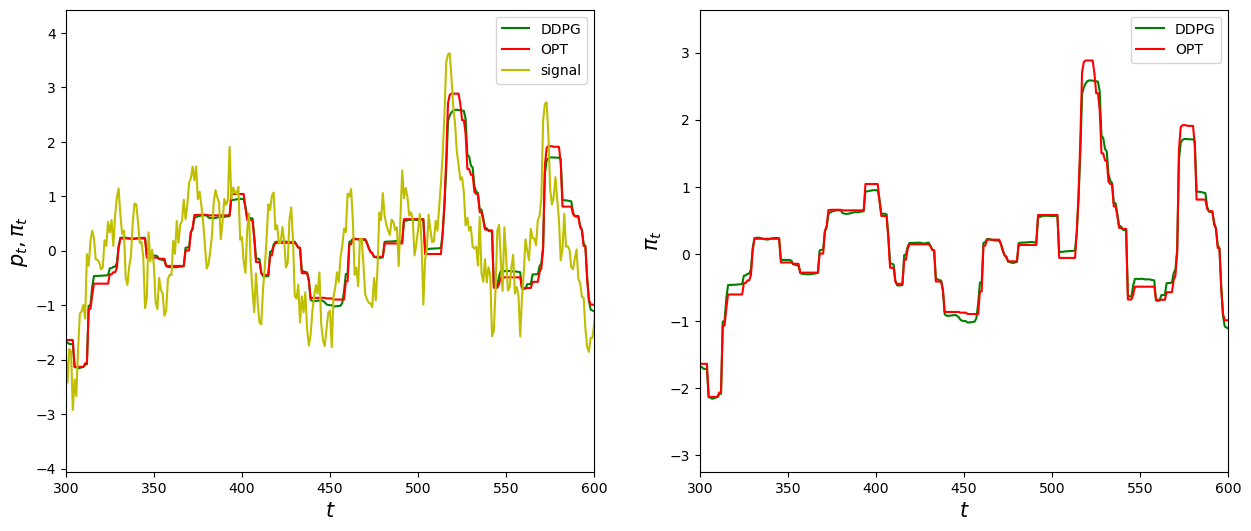

In [34]:
env.reset(random_state=730001)
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(positions[500][730001], label="DDPG", color="g")
plt.plot(positions_opt[730001], label="OPT", color="r")
plt.plot(env.signal[1:], label="signal", color="y")
plt.xlim(300, 600)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$p_t, \pi_t$", fontsize=15)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(positions[500][730001], label="DDPG", color="g")
plt.plot(positions_opt[730001], label="OPT", color="r")
plt.xlim(300, 600)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\pi_t$", fontsize=15)
plt.legend()

plt.savefig("positions_penalty.png")
plt.show()

Etant donné un signal revenu prévisible, on voit que les positions prises par l'agent suivent de manière similaire la solution optimale. 

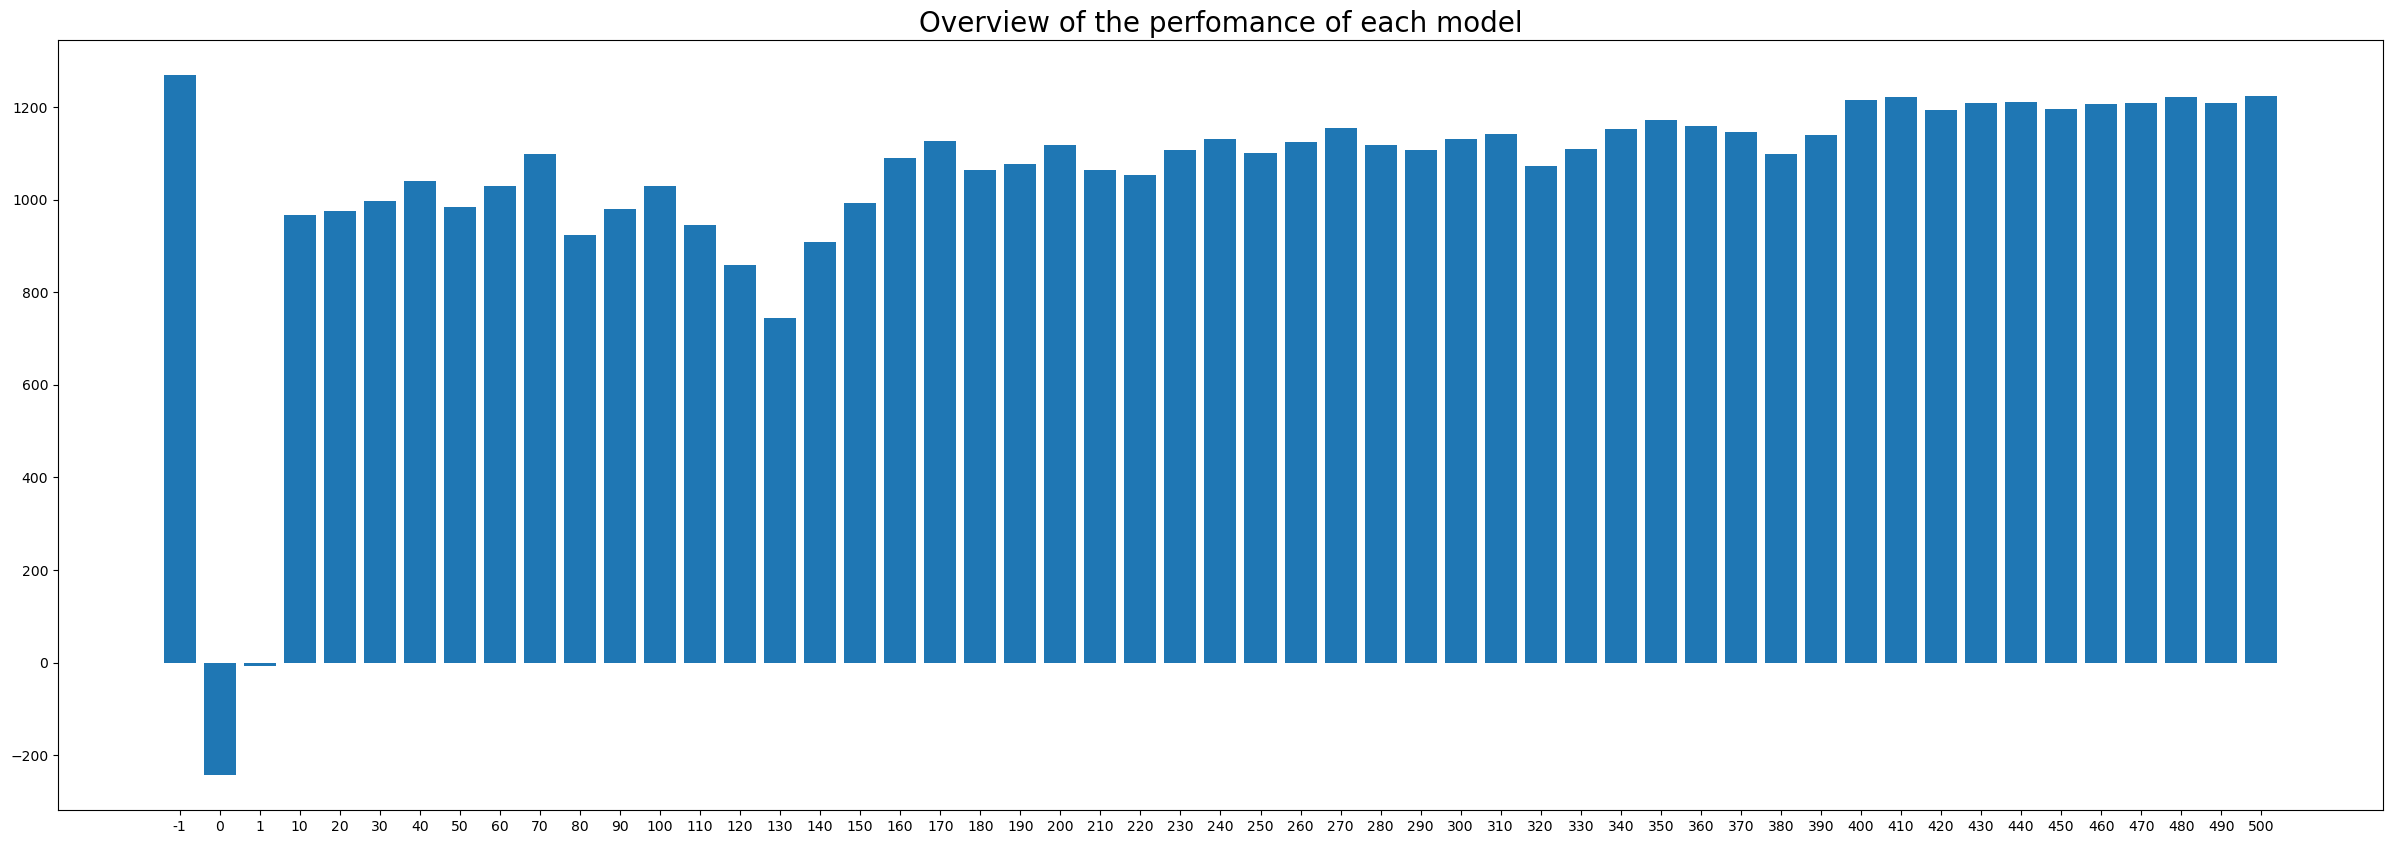

In [35]:
plot_bars(scores)

In [36]:
sorted_scores = sorted(scores.values(), reverse=True)
print("Optimal agent score   : %.2f" % sorted_scores[0])
print("Best DDPG agent score : %.2f" % sorted_scores[1])

Optimal agent score   : 1269.01
Best DDPG agent score : 1224.33


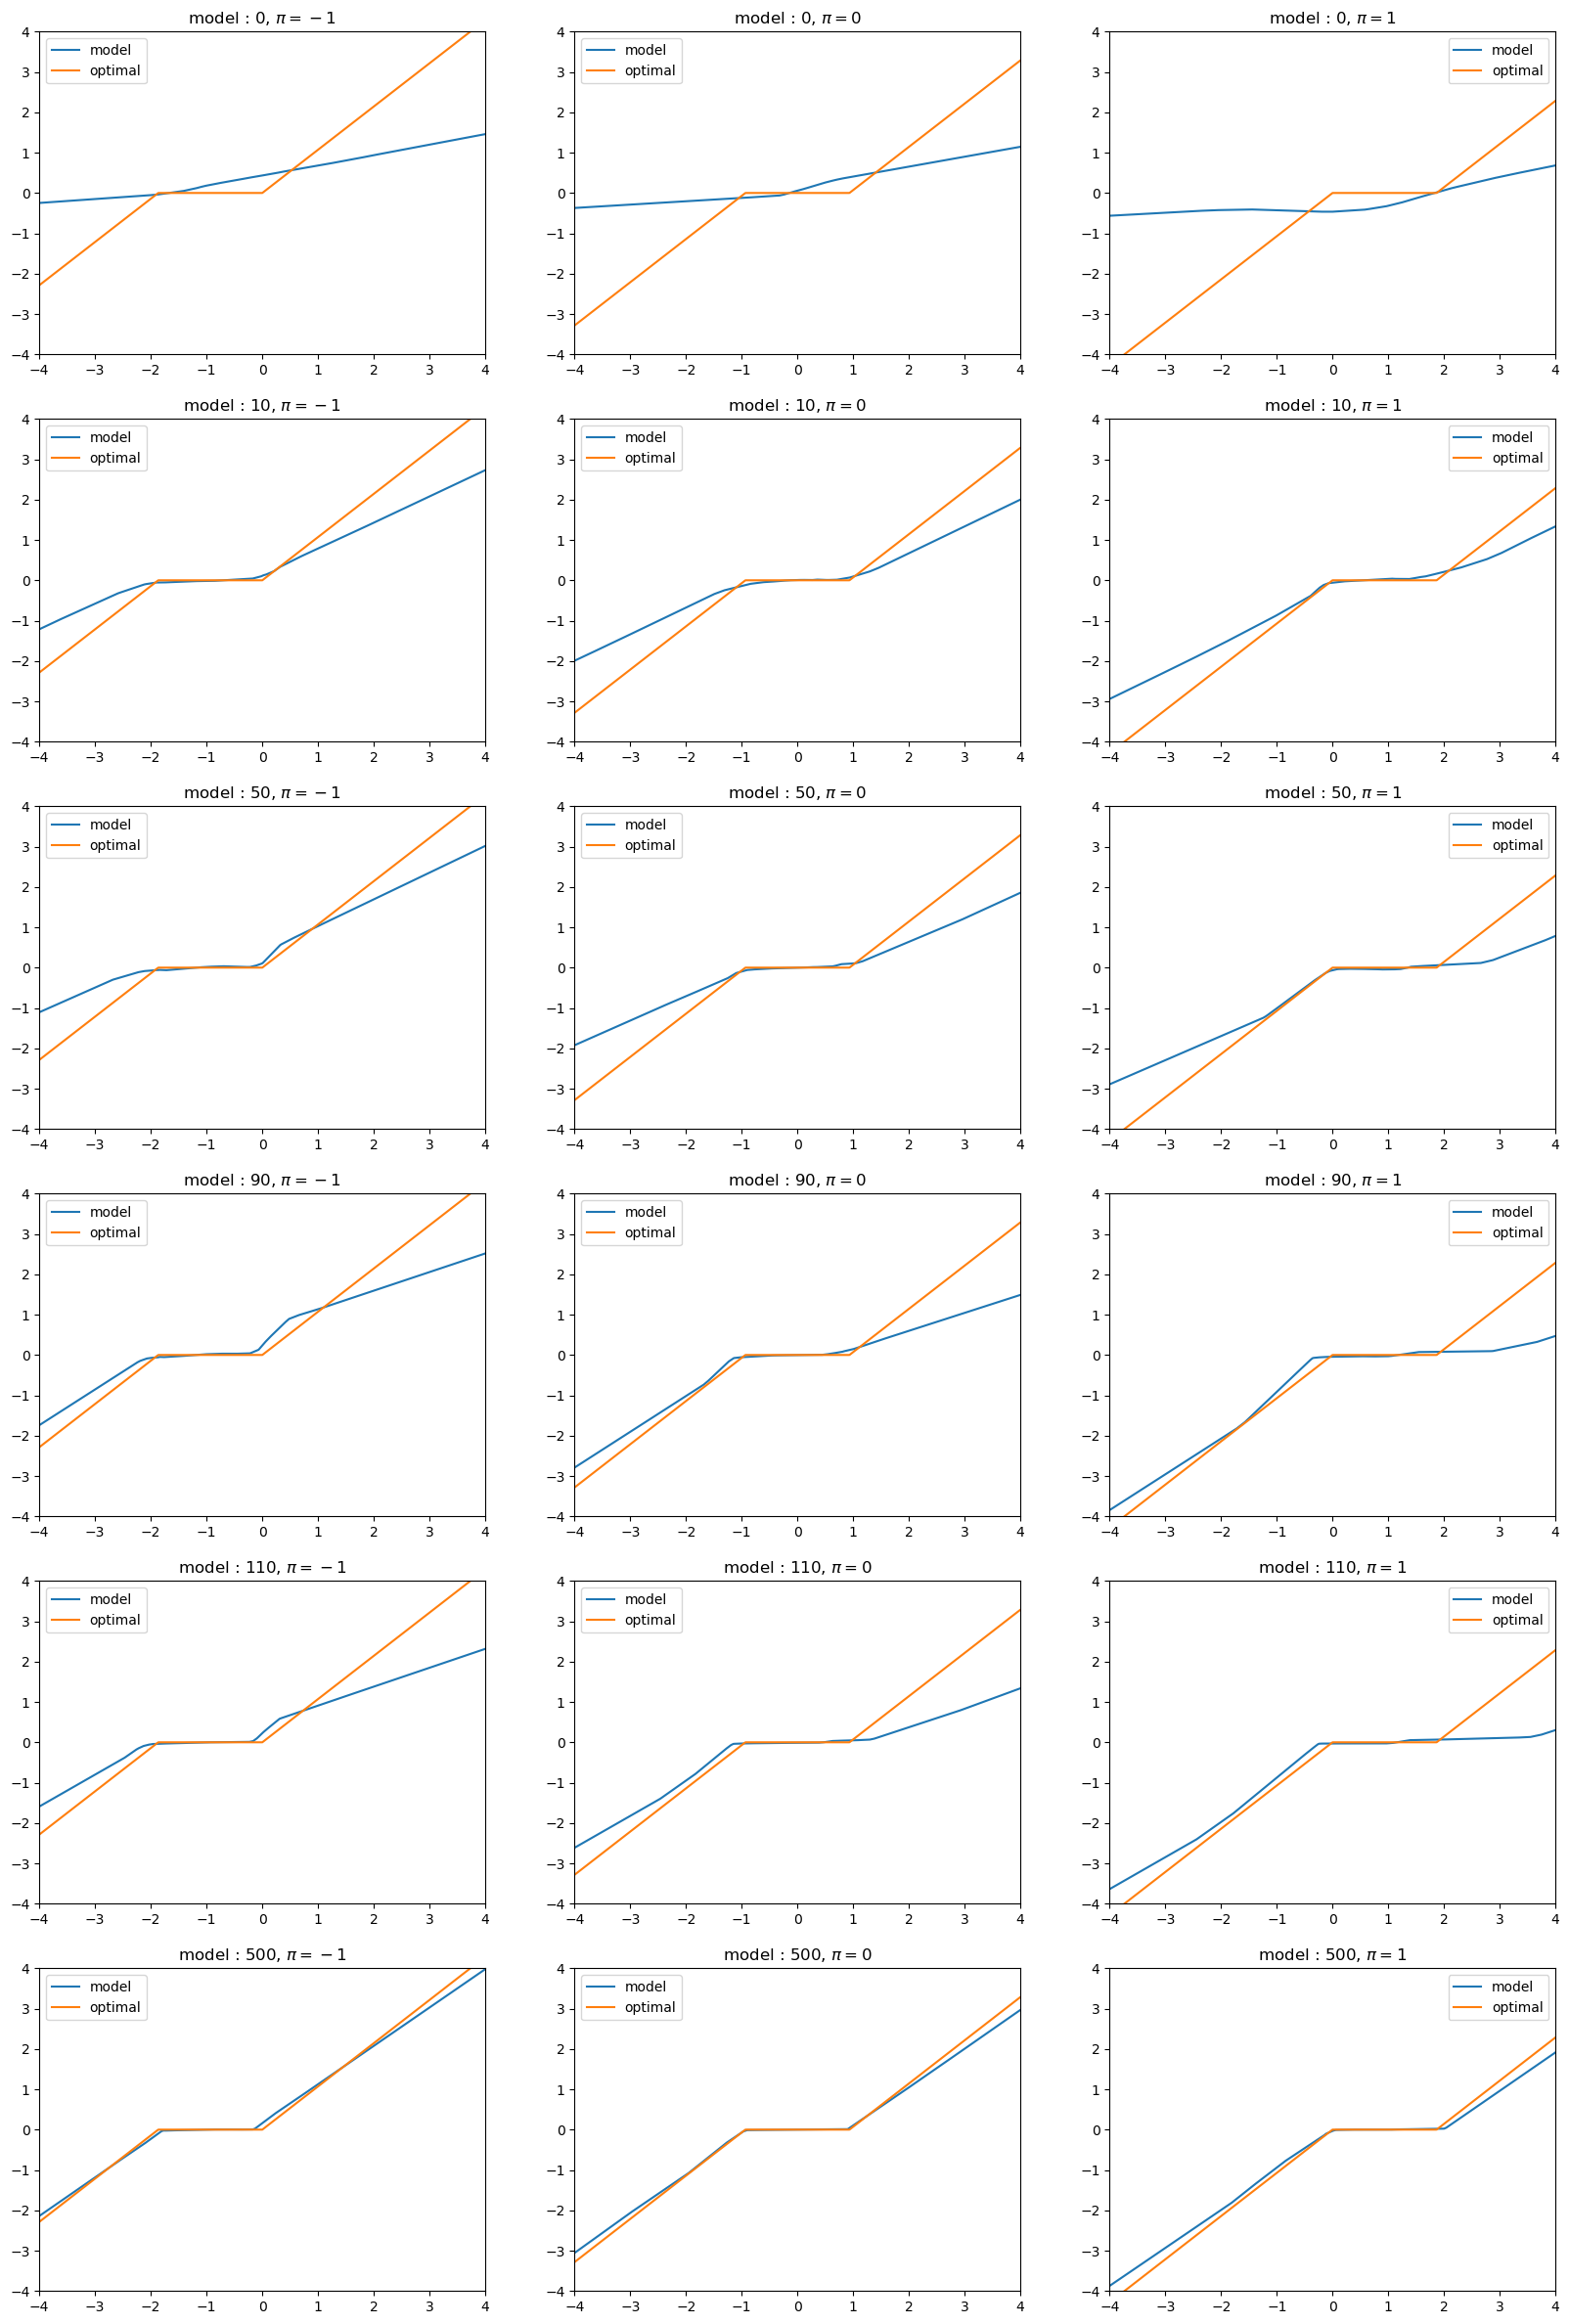

In [37]:

path_weights = "Experiment_linear_trading_cost_true_per/weights/"
models_keys = [0, 10, 50, 90, 110,500]
plot_function(
    path_weights,
    env,
    models_keys,
    low=-4,
    high=4,
    pi = 1, #sont montrés les positions -pi, 0, pi
    lambd=lambd_max,
    Gamma=Gamma_max,
    fc1_units=16,
    fc2_units=16,
)

## Coût proportionnel et risque *maxpos*

Deux manière de modéliser le problèmes sont possibles::

$$\textrm{rwd}_t = \pi_{t+1} p_{t+1} - \Gamma | a_{t}|;\hspace{2mm} $$

$\Gamma > 0$ et on rogne les positions dans l'intervalle $\left[-M, M\right]$; ce qui veut dire que l'agent n'est pas pénalisé pour effectuer une action $a_{t-1}$ qui le met dans une position $\pi_t$ au delà de $M$, *i.e* $|\pi_t + a|>M$,et la prochaine position est $|\pi_{t+1}|=M$.

La deuxième manière, plus complexe, ne rogne pas les positions mais pénalise l'agent lorsqu'il prend une action qu'il le fait dépsser la postion maximale. Cela est fait en ajoutant une fonction de pénalité continue, ici  une barrière $tanh$ :
$$\textrm{rwd}(p,\pi,a) = p\pi - \Gamma |a| -\beta\{\tanh[\alpha(|\pi +a| + (1+\gamma)M] +1\};\hspace{2mm} \Gamma,
\alpha, \beta, \gamma > 0 $$

Cette pénalité ne diverge pas pour $|\pi|$ élevé, ce qui la rend plus efficace qu'une pénalité constante `constant` ou exponentielle `exp`.

**Solution optimale par** ***GridSearch***

$$
a^*\left(\pi_{t-1}, p_t \right) =
\begin{cases}
M - \pi_{t-1}; \hspace{2mm} p_t > \widetilde{q} \\
0 \hspace{13mm}; \hspace{2mm} |p_t| \le \widetilde{q} \\
-M - \pi_{t-1}; \hspace{2mm} p_t < -\widetilde{q}
\end{cases}
$$

$\widetilde{q}$ est trouvé par *GridSearch*.

**Environment**

On utilise les paramètres suivants:
$$
\begin{cases}
\rho = 0.1 \\
\sigma = 0.1 \\
T = 5000 \\
M = 2 \\
\Gamma = 4
\end{cases}
$$

In [8]:
SIGMA = 0.1
RHO = 0.1
T = 5000
MAXPOS = 2
GAMMA = 4.0

env = Environment(
    sigma=SIGMA,
    rho=RHO,
    T=T,
    Gamma=GAMMA,
    cost="trade_l1", #coùt  proportionnel 
    squared_risk=False, # pas de risque quadratique
    max_pos=MAXPOS, #Position maximale
    clip=True, #Rognage
    penalty="tanh", #ou exp pour exponentielle ou constant pour constante
)

alpha, beta, gamma = 10, 10, MAXPOS / 4

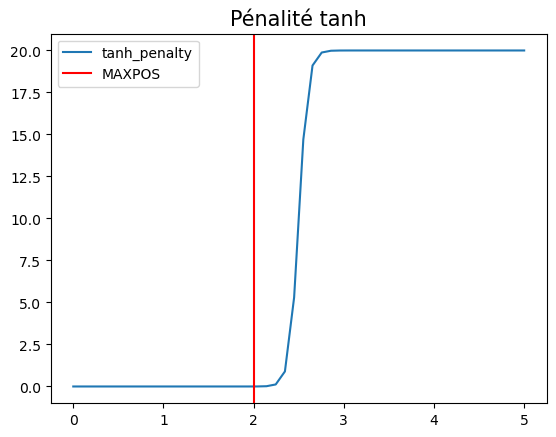

In [9]:
def tanh_penalty(pi):
    return beta * (np.tanh(alpha * (abs(pi) - MAXPOS - gamma)) + 1)


plt.plot(np.linspace(0, 5), tanh_penalty(np.linspace(0, 5)), label="tanh_penalty")
plt.axvline(MAXPOS, color="r", label="MAXPOS")
plt.title("Pénalité tanh", fontsize=15)
plt.legend()
plt.savefig("tanh_barrier.png")
plt.show()


### Entraînement

In [10]:
# Paramètres de l'agent
MAX_STEPS = 5000 #nombre de pas dans un épisode
MEMORY_TYPE = "prioritized" #ou uniform pour une mémoire uniformisée
SLIDING = "oldest" #ou "random" si on veut supprimer aléatoirement les expériences du replay buffer
BATCH_SIZE = 2 ** 9 # taille du batch
MAX_SIZE = int(1e6) # taille maximum du replay buffer


# Paramètres d'entraînement 
TOTAL_EPISODES = 501 #pour avoir les poids à la 500ème itération
TOTAL_STEPS = 10000
FREQ = 10
LEARN_FREQ = 50
TAU_ACTOR = 0.3
TAU_CRITIC = 0.1
LR_ACTOR = 1e-3
LR_CRITIC = 1e-2
WEIGHTS_DECAY_ACTOR = 0
WEIGHTS_DECAY_CRITIC = 0
FC1_UNITS_ACTOR = 16
FC2_UNITS_ACTOR = 16
FC1_UNITS_CRITIC = 16
FC2_UNITS_CRITIC = 16

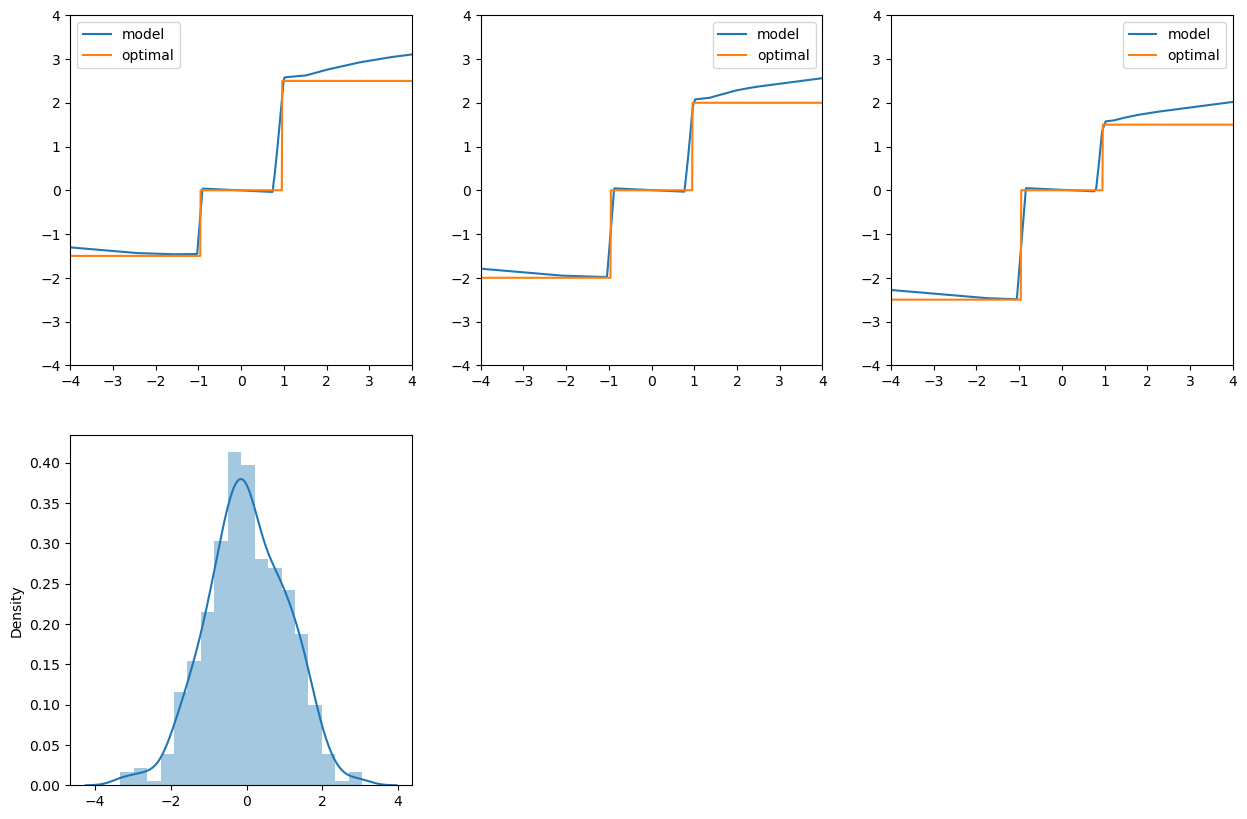

Wall time: 2h 12min 2s


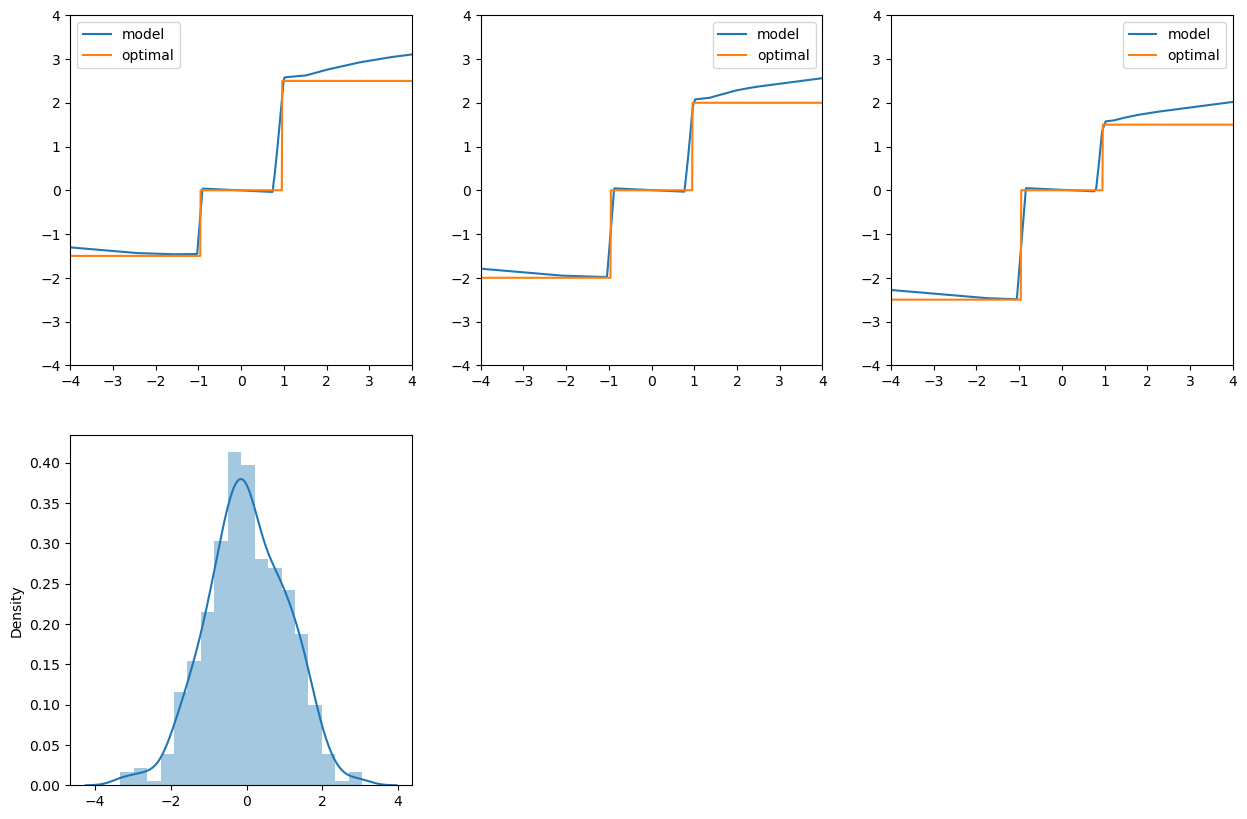

In [11]:
%%time
agent = Agent(
    max_size=MAX_SIZE,
    max_step=MAX_STEPS,
    memory_type=MEMORY_TYPE,
    sliding=SLIDING,
    batch_size=BATCH_SIZE,
    alpha=0.6,
    theta=0.1,
)

path = "Experiment_maxpos/"
if not os.path.exists(path + "weights/"):
    os.makedirs(path + "weights/")

agent.train(
    env=env,
    total_episodes=TOTAL_EPISODES,
    tau_actor=TAU_ACTOR,
    tau_critic=TAU_CRITIC,
    lr_actor=LR_ACTOR,
    lr_critic=LR_CRITIC,
    weight_decay_actor=WEIGHTS_DECAY_ACTOR,
    weight_decay_critic=WEIGHTS_DECAY_CRITIC,
    total_steps=TOTAL_STEPS,
    weights=path + "weights/",
    freq=FREQ,
    fc1_units_actor=FC1_UNITS_ACTOR,
    fc2_units_actor=FC2_UNITS_ACTOR,
    fc1_units_critic=FC1_UNITS_CRITIC,
    fc2_units_critic=FC2_UNITS_CRITIC,
    learn_freq=LEARN_FREQ,
    plots=True,
    thresh=0.95,
    tensordir=path + "runs/",
    mile=100,
    decay_rate=1e-5,
)

### Evaluation

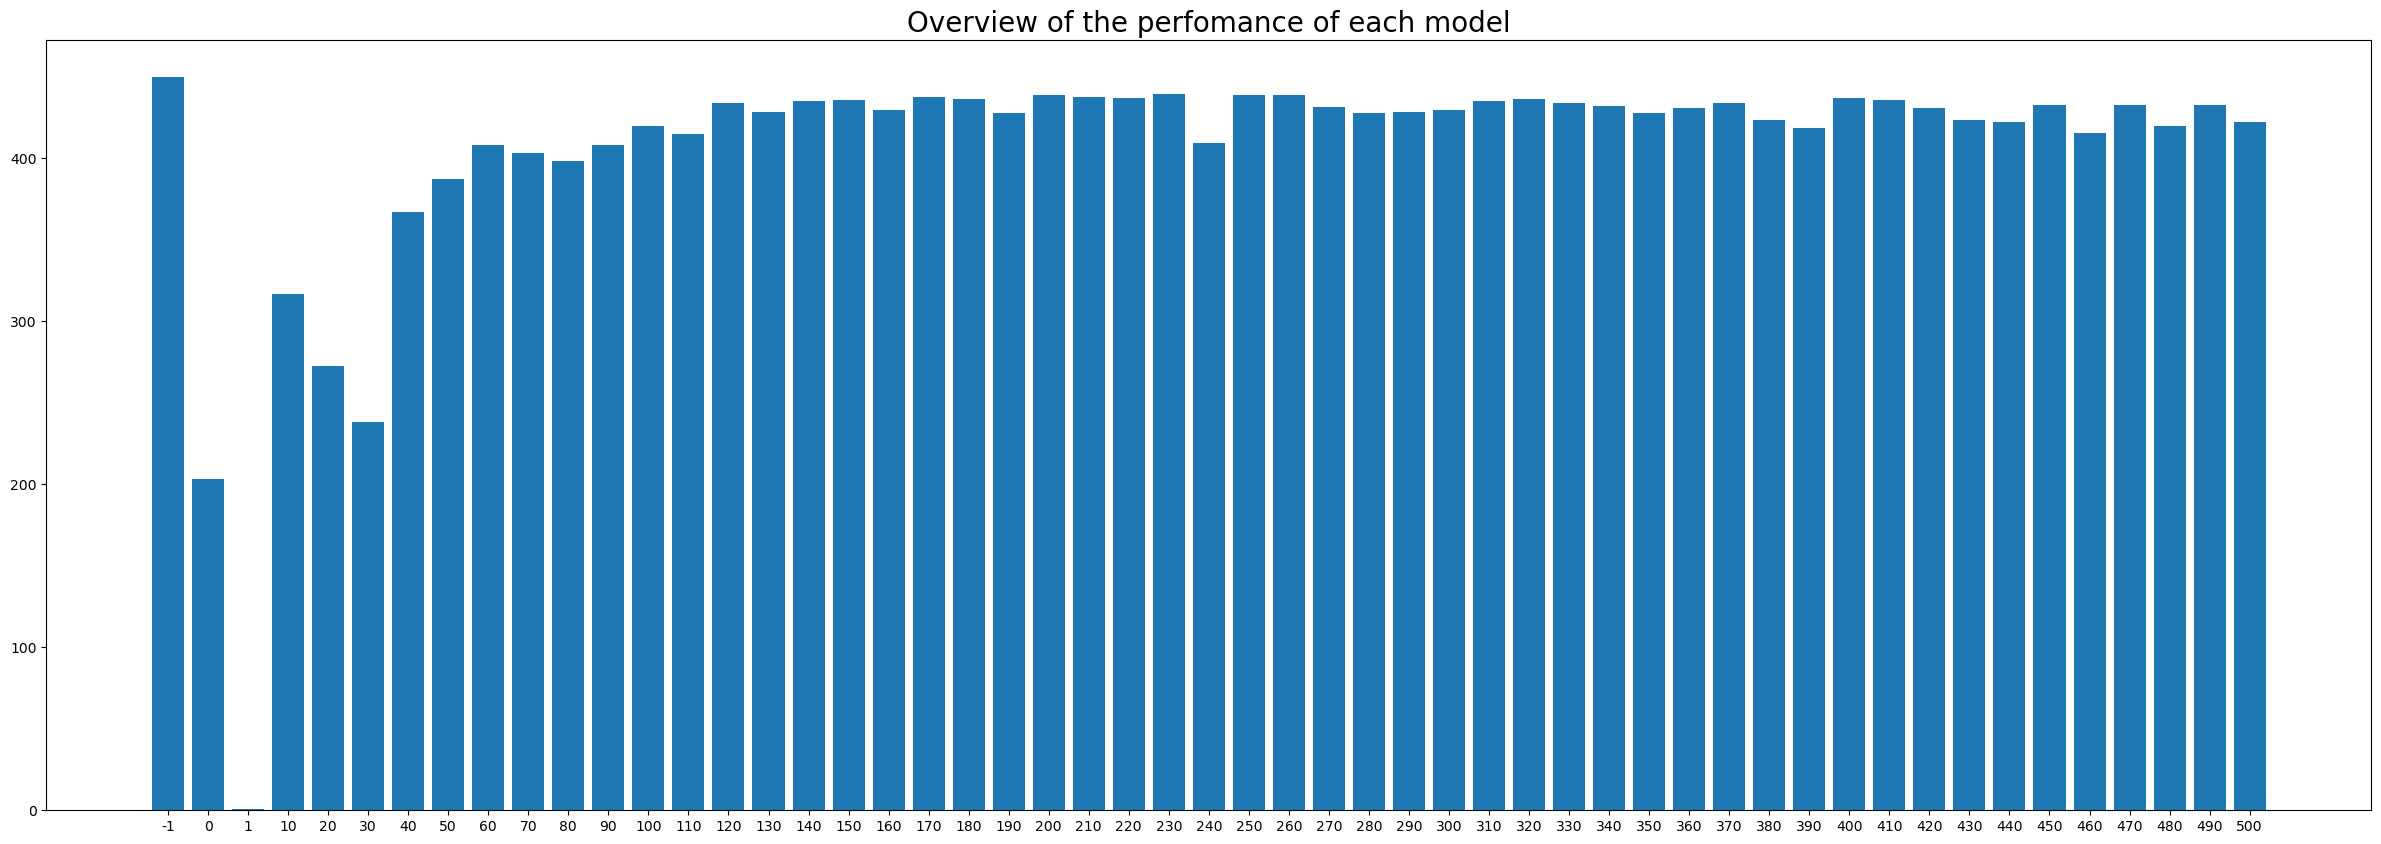

In [12]:
path_weights = "Experiment_maxpos/weights/"
scores, scores_episodes, scores_cumsum, pnls, positions = test_models(
    path_weights, env, n_episodes=10, fc1_units=16, fc2_units=16
)

random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)
score, score_episode, scores_cumsum_opt, pnls_opt, positions_opt = env.test_apply(
    total_episodes=n_episodes, random_states=random_states, thresh=0.95
)
scores[-1] = score
scores_episodes[-1] = score_episode

plot_bars(scores)



In [13]:
sorted_scores = sorted(scores.values(), reverse=True)
print("Optimal agent score   : %.2f" % sorted_scores[0])
print("Best DDPG agent score : %.2f" % sorted_scores[1])

Optimal agent score   : 449.92
Best DDPG agent score : 439.54


In [14]:
sorted_scores = sorted(scores.values(), reverse=True)
print("Optimal agent score   : %.2f" % sorted_scores[0])
print("Best DDPG agent score : %.2f" % sorted_scores[1])

Optimal agent score   : 449.92
Best DDPG agent score : 439.54


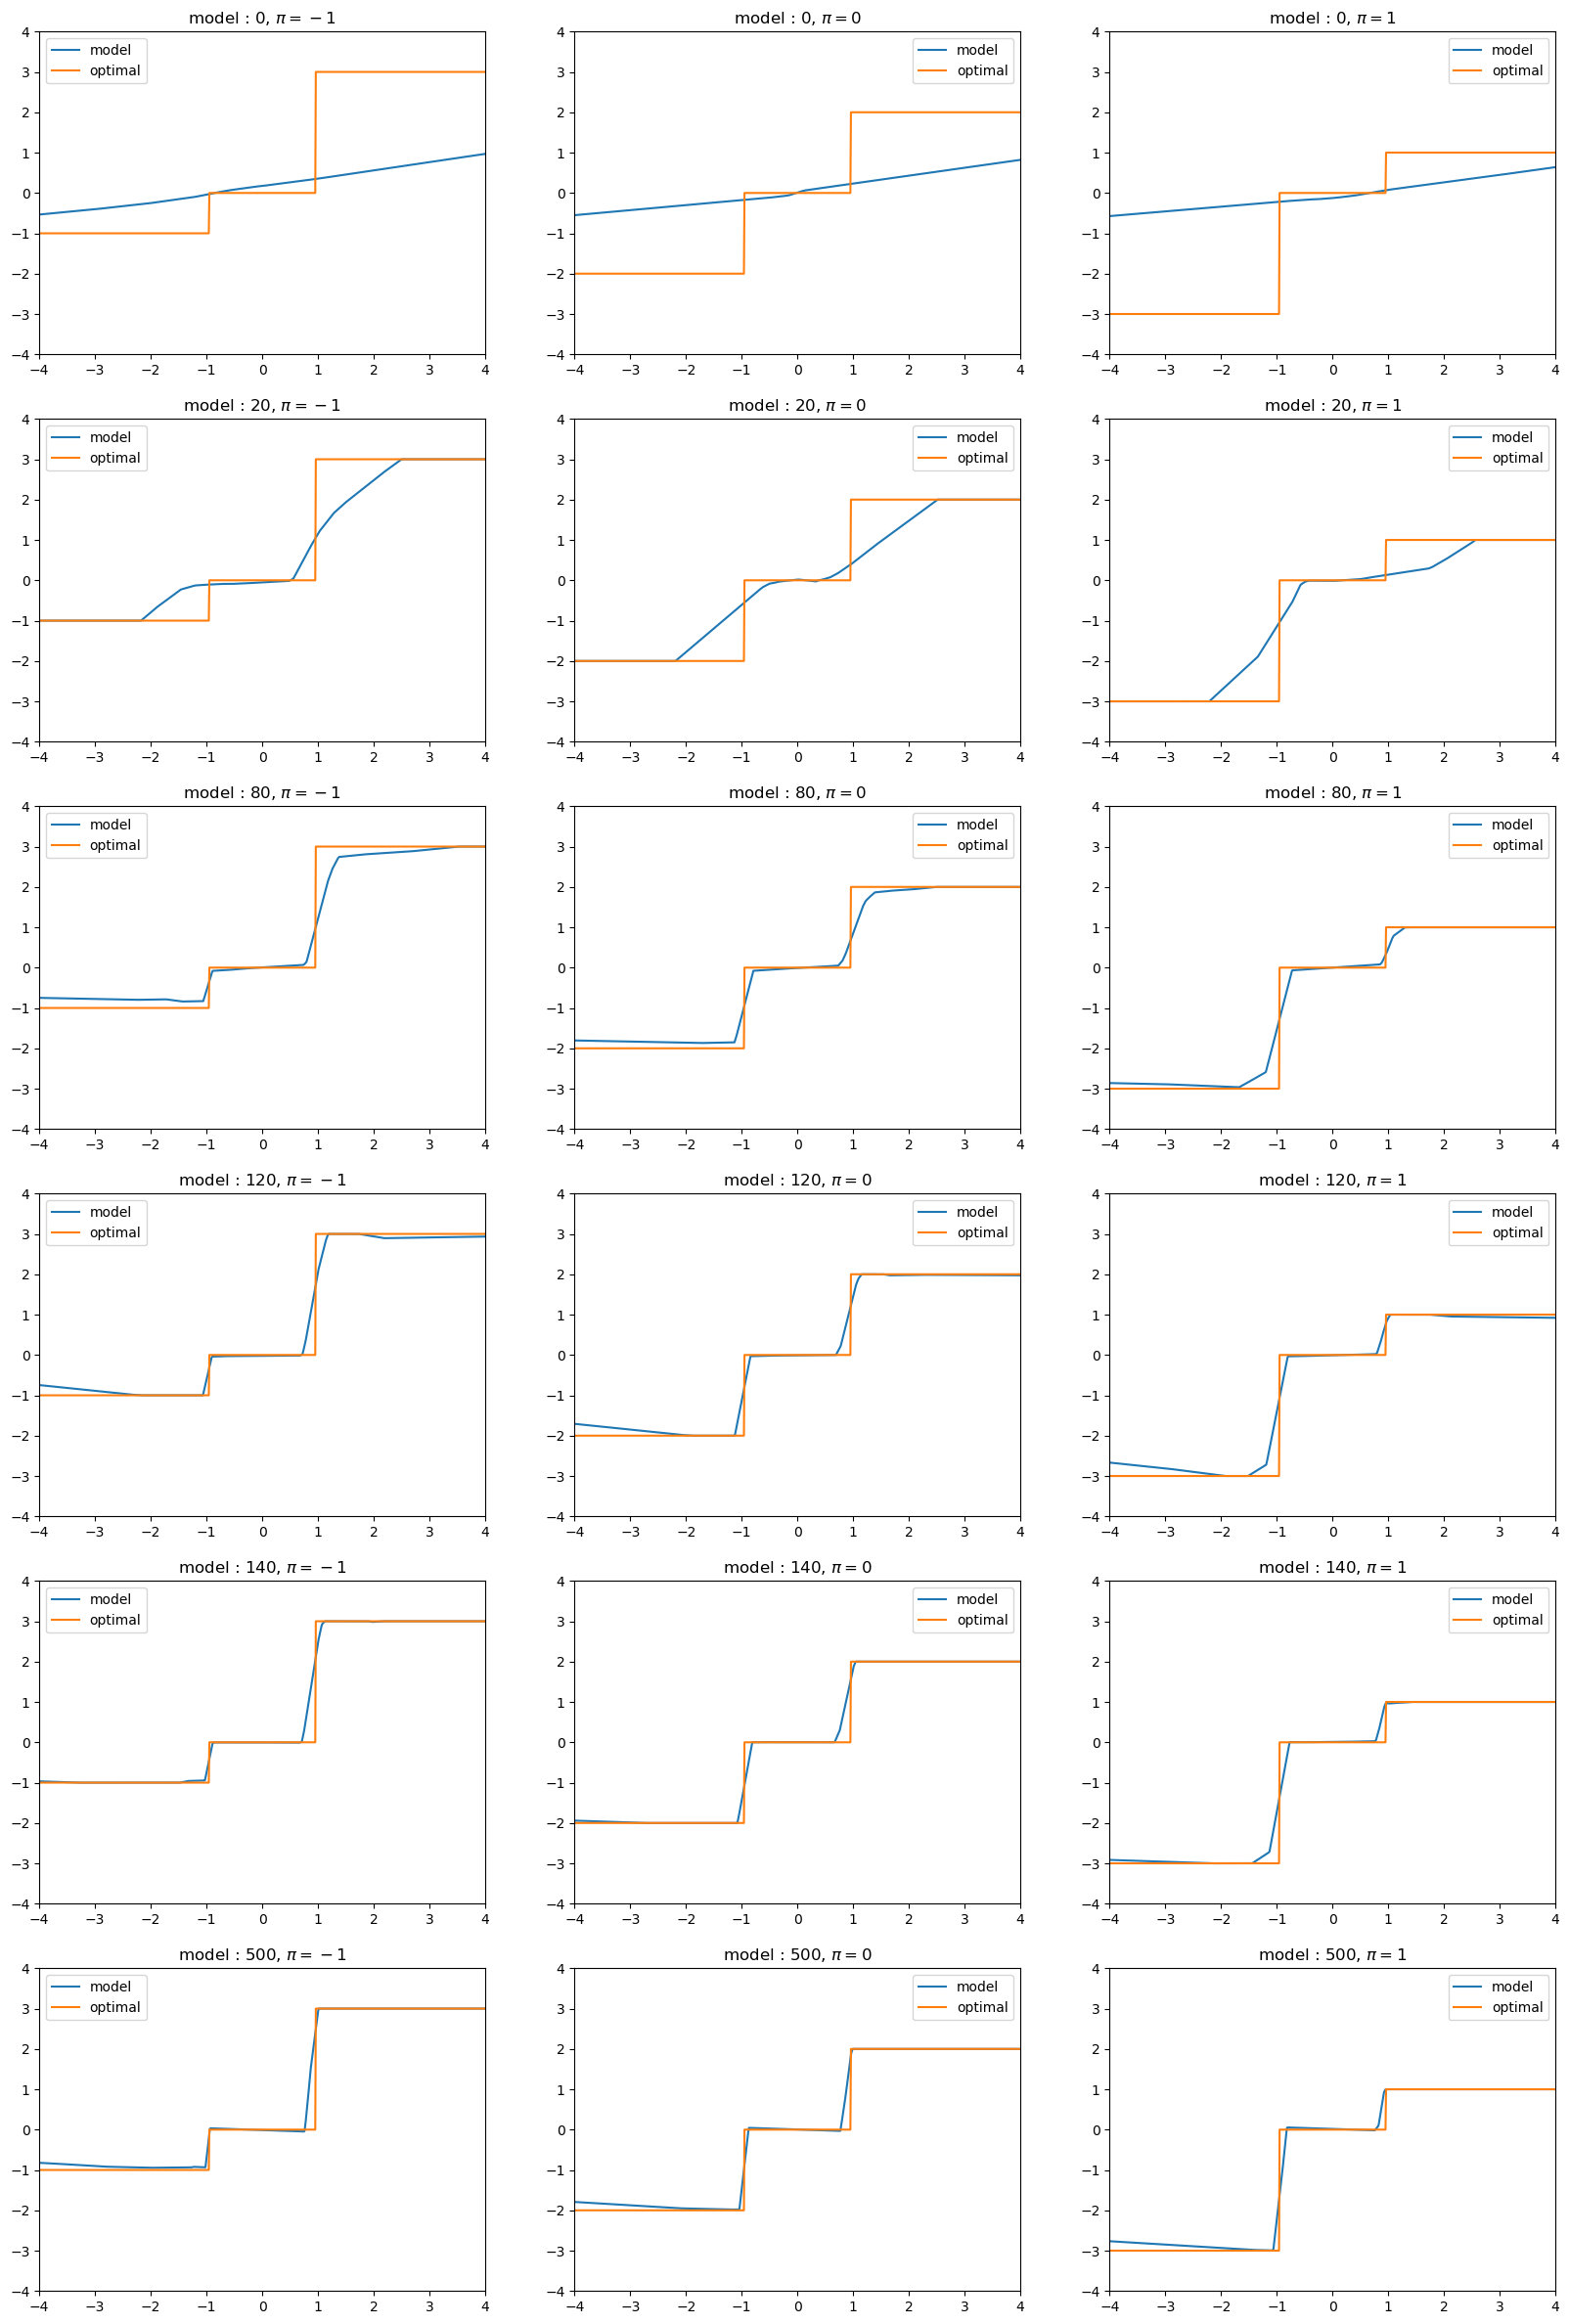

In [15]:
models_keys = [0, 20, 80, 120, 140, 500]
plot_function(
    path_weights,
    env,
    models_keys,
    low=-4,
    high=4,
    lambd=0.3,
    fc1_units=16,
    fc2_units=16,
    thresh=0.95,
    pi=1,
    clip=True,
)

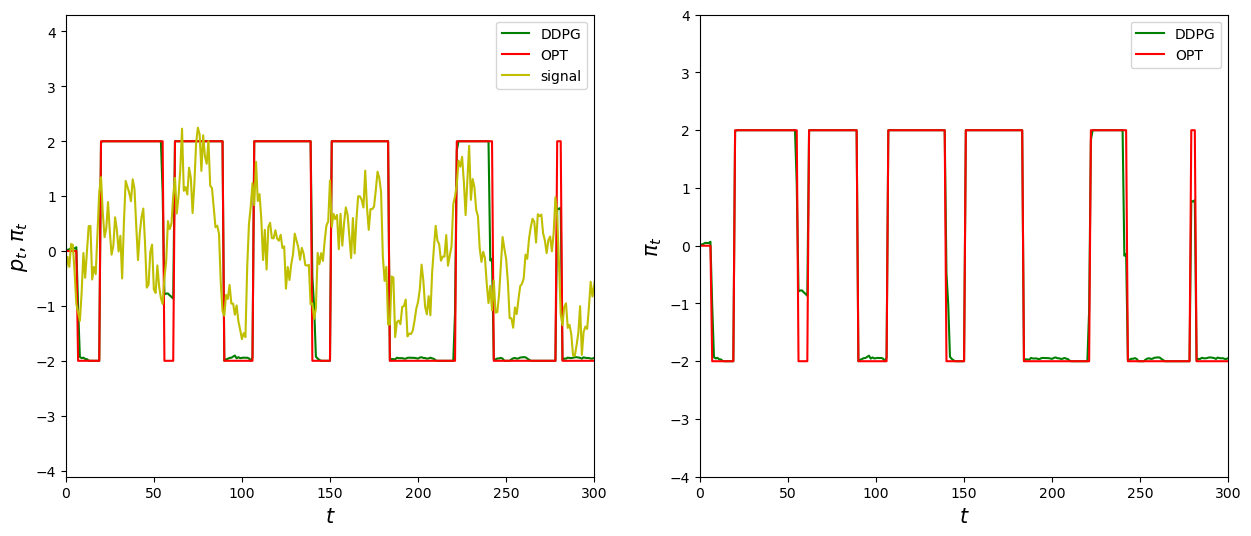

In [16]:
env.reset(random_state=989115)
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(positions[500][989115], label="DDPG", color="g")
plt.plot(positions_opt[989115], label="OPT", color="r")
plt.plot(env.signal[1:], label="signal", color="y")
plt.xlim(0, 300)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$p_t, \pi_t$", fontsize=15)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(positions[500][989115], label="DDPG", color="g")
plt.plot(positions_opt[989115], label="OPT", color="r")
plt.xlim(0, 300)
plt.ylim(-4, 4)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\pi_t$", fontsize=15)
plt.legend()

plt.savefig("positions_constraint_per.png")
plt.show()

## Coût et risque quadratique

On considère la fonction de gain suivante :

$$
\pi_{t+1} p_{t} - \Gamma a_t^2 - \lambda\pi_{t+1}^2;\hspace{2mm} \lambda, \Gamma > 0
$$

**Solution optimale**

L'expression explicite s'obtient en prenant le gain moyen à horizon infini (\emph{i.e.} en divisant le gain total par $T$, puis en prenant la limite $T\to \infty$) : 
\begin{equation}
    a_t = - Ks_t
\end{equation}
avec $K$ unique solution d'un système d'Équations Différentielles Oridnaires (EDO) de Riccatti, qui dépend linéairement de l'état.

Sans le terme de coût, la solution suit une allocation de Marcowitz : 
\begin{equation}
    \pi_{t+1}^* = \pi_{t+1}^{(M)}=\frac{p_t}{2\lambda}
\end{equation}
La composante coût modifie l'allocation de Marcowitz qui s'exprime s'écrit alors comme un lissage exponentielle  :
\begin{equation}
    \pi_{t+1}^* = (1-\omega)\pi_t + \omega \psi \pi_{t+1}^{(M)}
\end{equation}
avec $\psi = \frac{\omega}{1-(1-\omega)\rho}$, $\omega = f_c\left(\sqrt{\frac{\lambda}{T}}\right)$ et $f_c(x) = \frac{2}{1 +\sqrt{1+\frac{4}{x}}}=\frac{x}{2}(\sqrt{x^2 +4}-x)$


$\omega$ est obtenu par *GridSearch*.

**Environment**

On utilise les paramètres suivants:
$$
\begin{cases}
\rho = 0.1 \\
\sigma = 0.1 \\
T = 5000 \\
\lambda = 0.3 \\
\Gamma = 1
\end{cases}
$$



In [38]:
SIGMA = 0.1
RHO = 0.1
T = 5000
LAMBD = 0.3
GAMMA = 1

env = Environment(
    sigma=SIGMA,
    rho=RHO,
    T=T,
    lambd=LAMBD,
    Gamma=GAMMA,
    cost="trade_l2", #coût quadratique
    scale_reward=10,
    squared_risk=True #avec risque quadratique
)

Le *GridSearch* permet d'estimer $\widetilde{\lambda},
\widetilde{\Gamma}$ par moyenne cumulative sur 10 épisodes.

In [39]:
%%time
import tqdm
random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)

lambds = np.linspace(0.2, 0.6, 10)
gammas = np.linspace(0.2, 0.6, 10)

# 1ère dim: lambdas; 2ème dim: gammas; 3ème dim: episodes
scores_episodes = np.empty((len(lambds), len(gammas), n_episodes))
scores = np.empty((len(lambds), len(gammas)))  # 1ère dim: lambdas; 2ème dim: gammas

for i, lambd in tqdm.tqdm_notebook(list(enumerate(lambds))):
    for j, Gamma in tqdm.tqdm_notebook(list(enumerate(gammas))):
        score, score_episode, _, _, _ = env.test_apply(
            total_episodes=n_episodes, random_states=random_states, lambd=lambd, Gamma=Gamma
        )
        scores[i, j] = score
        scores_episodes[i, j, :] = list(score_episode.values())
        # print('lambd=%.1f , Gamma=%.1f -> score=%.3f \n' % (lambd, Gamma, score))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 3min 15s


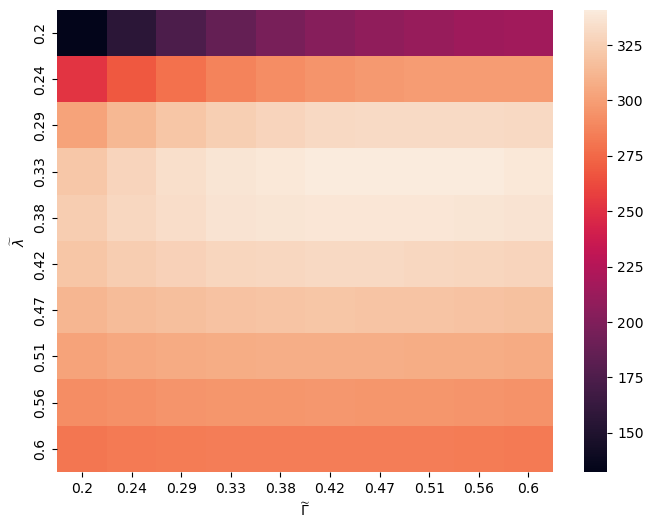

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.DataFrame(
        scores,
        index=pd.Index(np.round(lambds, 2), name=r"$\widetilde{\lambda}$"),
        columns=pd.Index(np.round(gammas, 2), name=r"$\widetilde{\Gamma}$"),
    )
)
plt.show()

In [41]:
i_max = np.argmax(scores) // scores.shape[0]
j_max = np.argmax(scores[i_max, :])

lambd_max, Gamma_max = lambds[i_max], gammas[j_max]
print("lambd_max=%.2f , Gamma_max=%.2f" % (lambd_max, Gamma_max))

lambd_max=0.33 , Gamma_max=0.47


On trouve $\widetilde{\lambda}=0.33, \widetilde{\Gamma}=0.47$

### Entraînement

In [21]:
# Paramètres d'agents
MAX_STEPS = 5000 #nombre de pas dans un épisode
MEMORY_TYPE = "prioritized" #ou uniform pour une mémoire uniformisée
SLIDING = "oldest" #ou "random" si on veut supprimer aléatoirement les expériences du replay buffer
BATCH_SIZE = 2 ** 9 # taille du batch
MAX_SIZE = int(1e6) # taille maximum du replay buffer

# Paramètres d'entraînements
TOTAL_EPISODES = 501 # pour avoir les poids de la 500ème itération
TOTAL_STEPS = 10000
FREQ = 10
LEARN_FREQ = 50
TAU_ACTOR = 0.3
TAU_CRITIC = 0.1
LR_ACTOR = 1e-3
LR_CRITIC = 1e-2
WEIGHTS_DECAY_ACTOR = 0
WEIGHTS_DECAY_CRITIC = 0
FC1_UNITS_ACTOR = 16
FC2_UNITS_ACTOR = 16
FC1_UNITS_CRITIC = 16
FC2_UNITS_CRITIC = 16

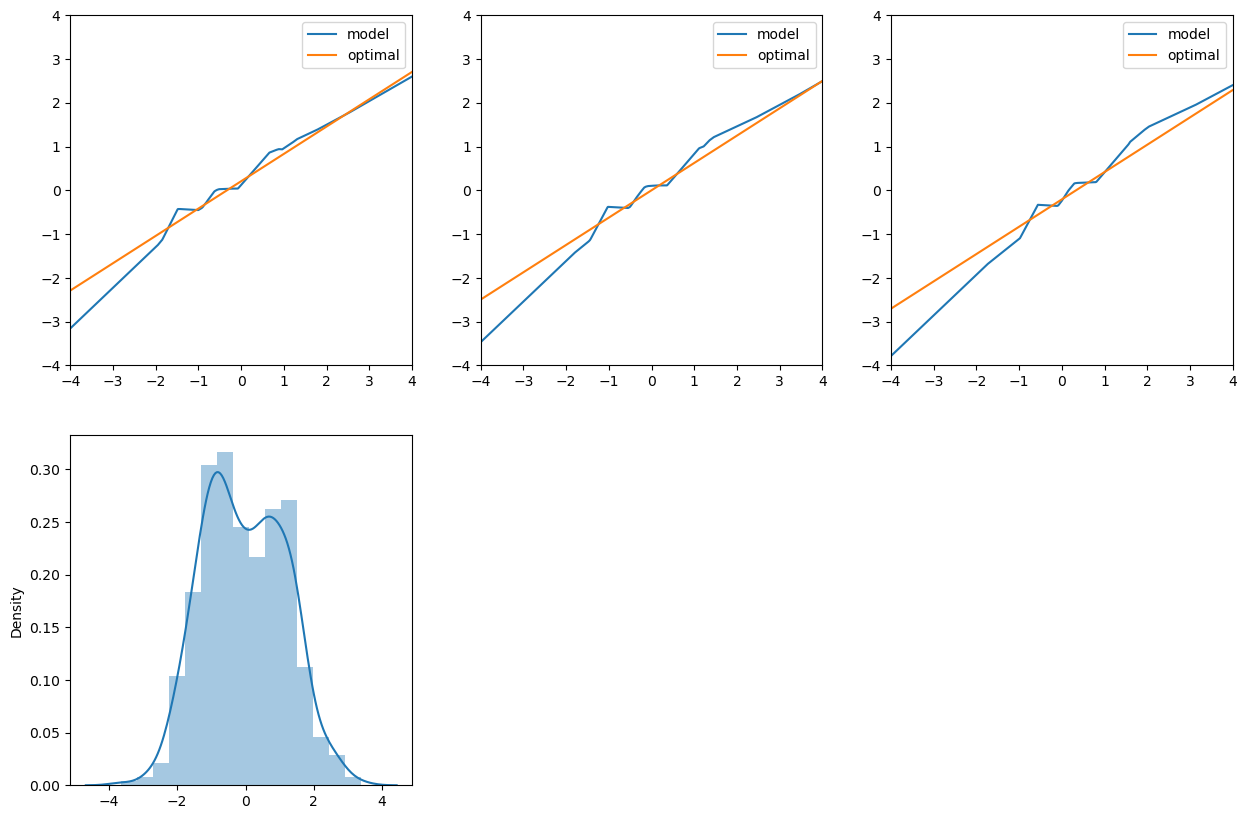

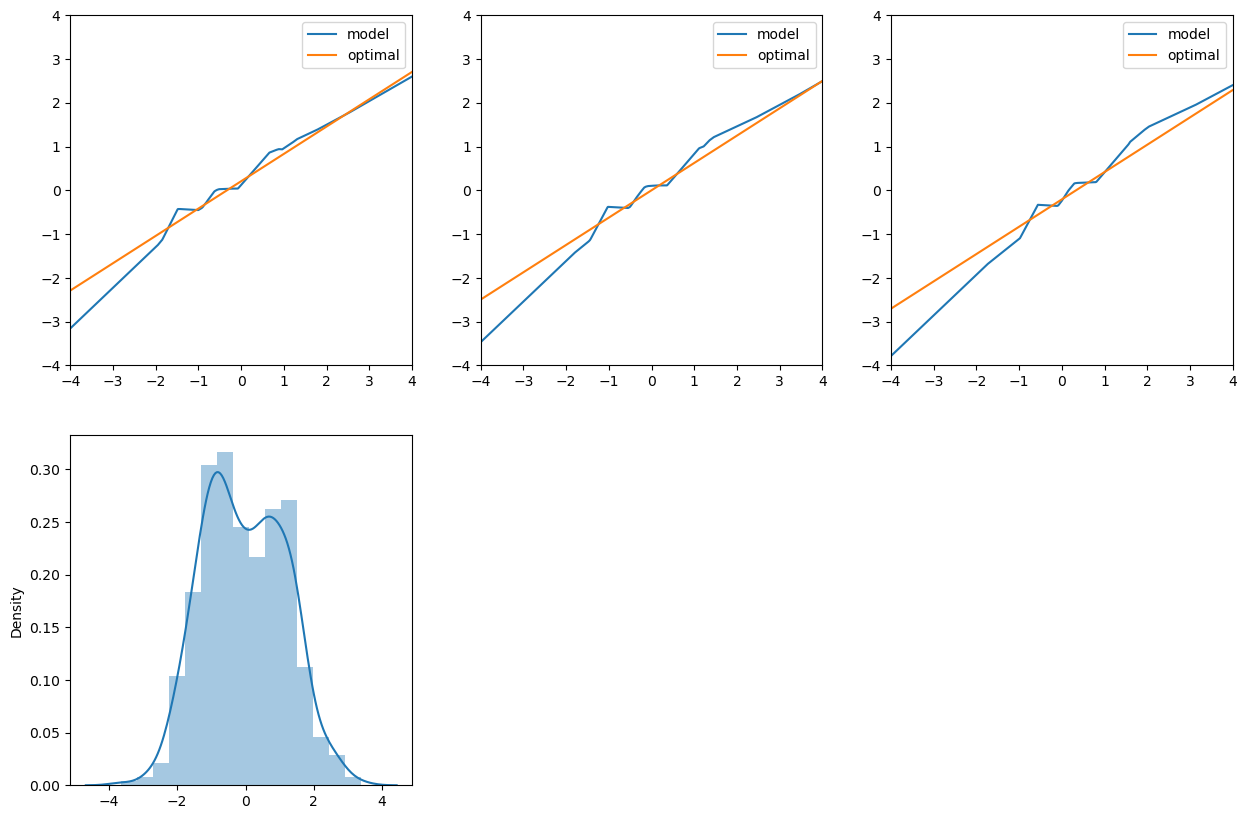

In [22]:
# %%time
path = "Experiment_squared_cost/"
if not os.path.exists(path + "weights/"):
    os.makedirs(path + "weights/")

agent = Agent(
    max_size=MAX_SIZE,
    max_step=MAX_STEPS,
    memory_type=MEMORY_TYPE,
    sliding=SLIDING,
    batch_size=BATCH_SIZE,
    alpha=0.6,
    theta=0.1,
)

agent.train(
    env=env,
    total_episodes=TOTAL_EPISODES,
    tau_actor=TAU_ACTOR,
    tau_critic=TAU_CRITIC,
    lr_actor=LR_ACTOR,
    lr_critic=LR_CRITIC,
    weight_decay_actor=WEIGHTS_DECAY_ACTOR,
    weight_decay_critic=WEIGHTS_DECAY_CRITIC,
    total_steps=TOTAL_STEPS,
    weights=path + "weights/",
    freq=FREQ,
    fc1_units_actor=FC1_UNITS_ACTOR,
    fc2_units_actor=FC2_UNITS_ACTOR,
    fc1_units_critic=FC1_UNITS_CRITIC,
    fc2_units_critic=FC2_UNITS_CRITIC,
    learn_freq=LEARN_FREQ,
    plots=True,
    lambd=lambd_max,
    Gamma=Gamma_max,
    tensordir=path + "runs/",
    mile=100,
    decay_rate=1e-5,
)

### Evaluation

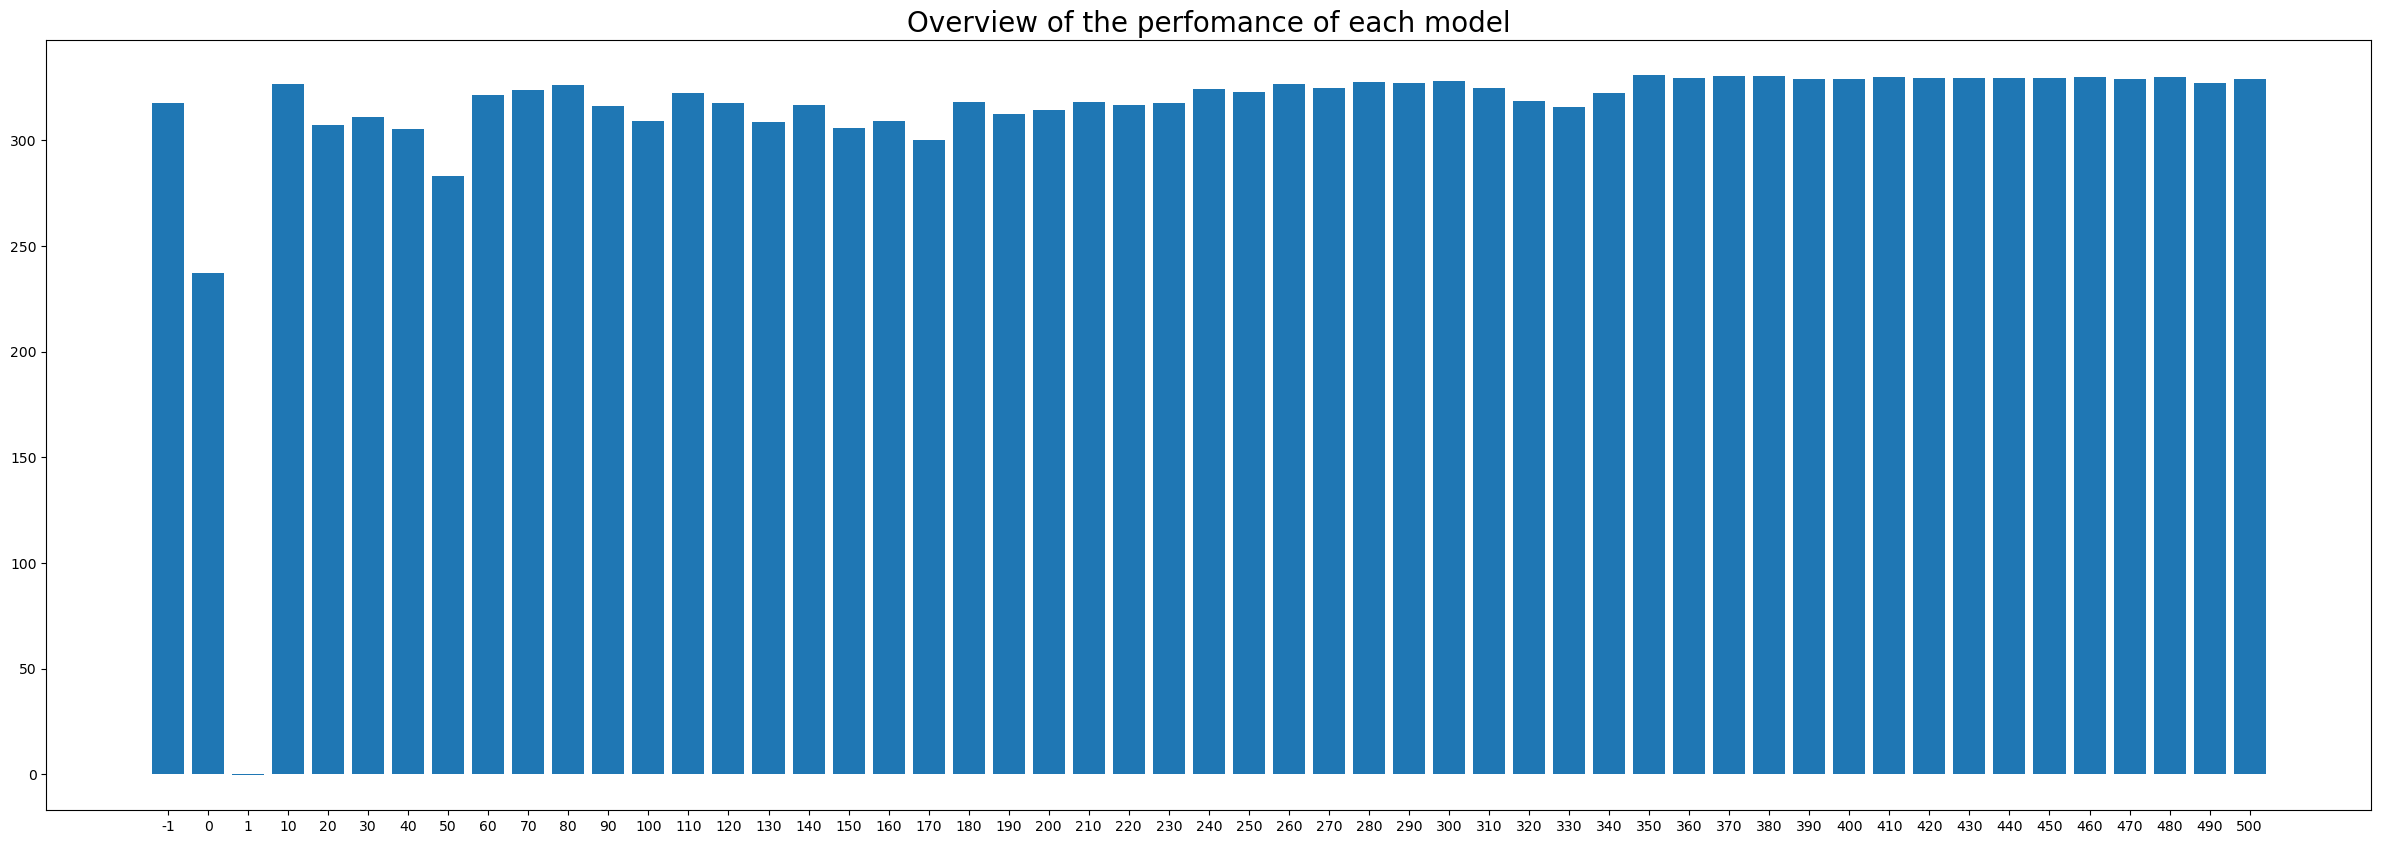

In [42]:
random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)
score, score_episode, scores_cumsum_opt, pnls_opt, positions_opt = env.test_apply(
    total_episodes=n_episodes, random_states=random_states, lambd=0.33, Gamma=0.47
)

path_weights = "Experiment_squared_cost/weights/"
scores, scores_episodes, scores_cumsum, pnls, positions = test_models(
    path_weights, env, n_episodes=10, fc1_units=16, fc2_units=16
)

random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)
score, score_episode, scores_cumsum_opt, pnls_opt, positions_opt = env.test_apply(
    total_episodes=n_episodes, random_states=random_states, thresh=0.95
)
scores[-1] = score
scores_episodes[-1] = score_episode

plot_bars(scores)

In [43]:
sorted_scores = sorted(scores.values(), reverse=True)
print("Optimal agent score   : %.2f" % sorted_scores[0])
print("Best DDPG agent score : %.2f" % sorted_scores[1])

Optimal agent score   : 330.83
Best DDPG agent score : 330.71


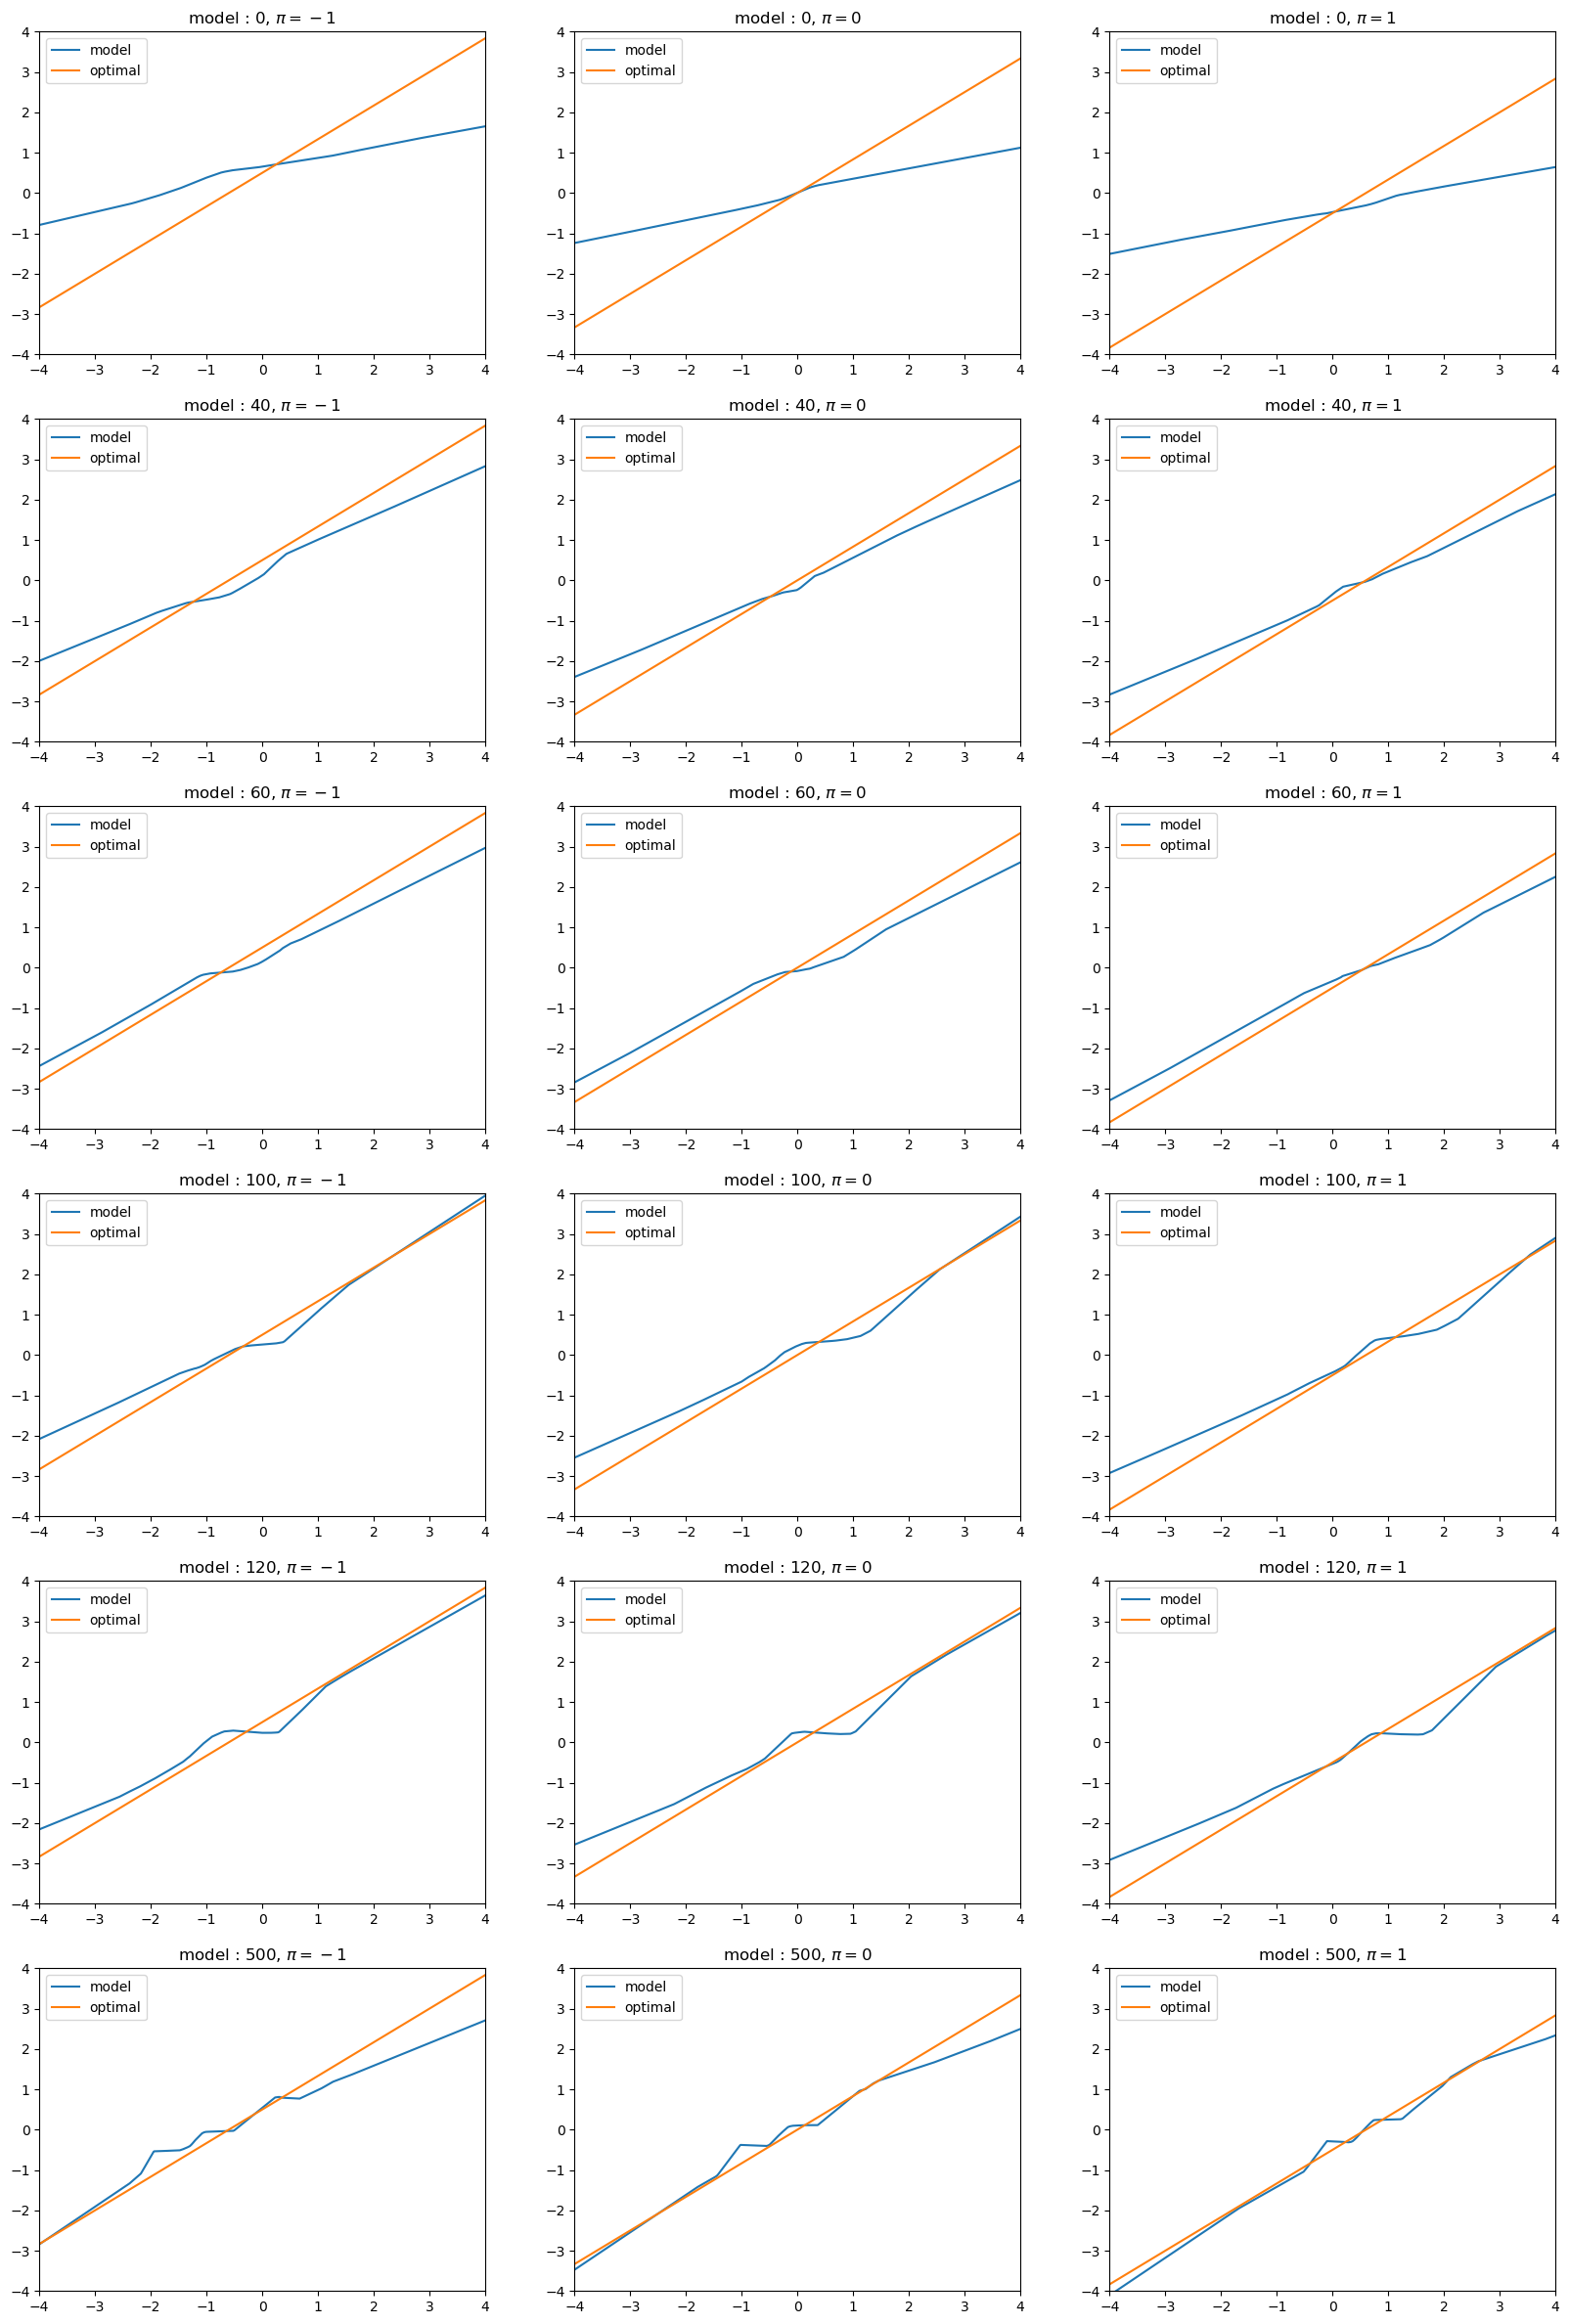

In [44]:
models_keys = [0, 40, 60, 100, 120,500]
plot_function(
    path_weights,
    env,
    models_keys,
    low=-4,
    high=4,
    lambd=0.3,
    fc1_units=16,
    fc2_units=16,
    thresh=0.95,
    clip=True,
    pi = 1
)

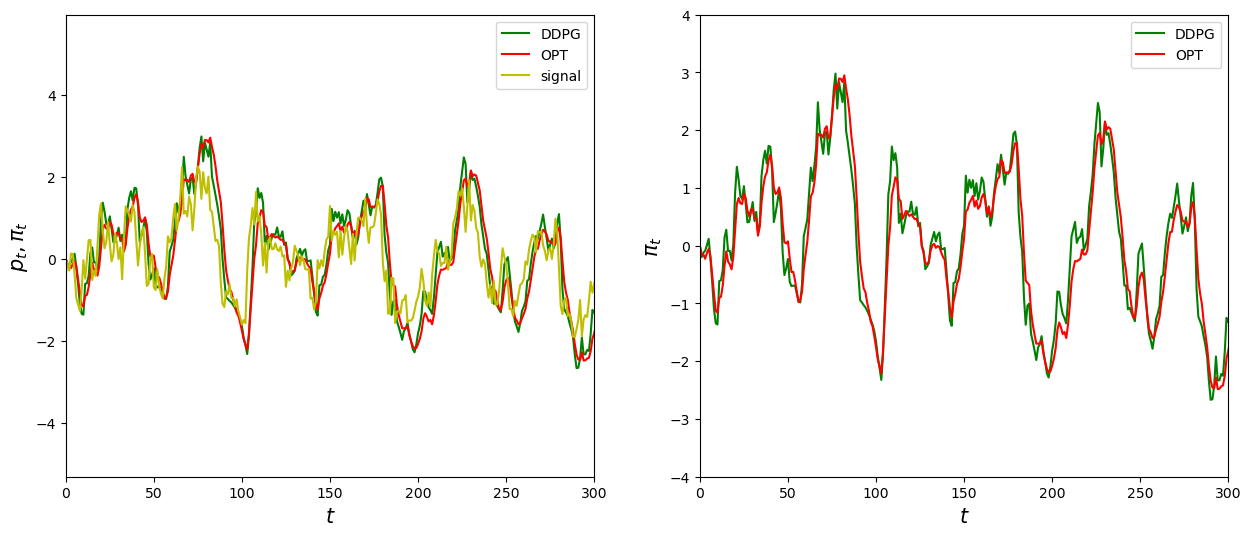

In [45]:
env.reset(random_state=989115)
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(positions[500][989115], label="DDPG", color="g")
plt.plot(positions_opt[989115], label="OPT", color="r")
plt.plot(env.signal[1:], label="signal", color="y")
plt.xlim(0, 300)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$p_t, \pi_t$", fontsize=15)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(positions[500][989115], label="DDPG", color="g")
plt.plot(positions_opt[989115], label="OPT", color="r")
plt.xlim(0, 300)
plt.ylim(-4, 4)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\pi_t$", fontsize=15)
plt.legend()

plt.savefig("positions_constraint_per.png")
plt.show()